# Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
    
import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.io.orca.config.executable = 'C:/Users/mina/AppData/Local/Programs/orca/orca.exe'
plotly.offline.init_notebook_mode(connected=True)
#plotly.io.orca.config.save()

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
# Options de Réglages sur l'Organisation, l'Affichage Qualitatif des Données
pd.set_option("display.max.columns", None) # Pour afficher toutes les colonnes
pd.set_option('display.max_rows', None) # Pour afficher toutes les lignes
pd.set_option("max_colwidth", 40) # Pour afficher les colonnes jusqu'à une largeur maxi
pd.set_option("precision", 4) # Pour afficher seulement n chiffres après la virgule*
pd.options.display.float_format = '{:.2f}'.format # Pour remplacer l'affichage scientifique des nombres en décimal
pd.options.mode.chained_assignment = None  # default='warn'

# Définition des Fonctions Utiles

In [3]:
def load_all_tables(directory_path = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/", verbose = True):
    
    '''
    Function to load all the tables required
    
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not
        
    '''
    
    if verbose:
        print("Loading all the tables...")
        start = datetime.now()
    
    #making all the variables global to be used anywhere in the notebook
    global application_train, application_test, bureau, bureau_balance, cc_balance, installments_payments, POS_CASH_balance, previous_application
    
    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Loaded 1 table.")
       
    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Loaded 2 tables.")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Loaded 3 tables.")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Loaded 4 tables.")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Loaded 5 tables.")

    installments_payments = pd.read_csv(directory_path + 'installments_payments.csv')
    if verbose:
        print("Loaded 6 tables.")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Loaded 7 tables.")

    previous_application = pd.read_csv(directory_path + 'previous_application.csv')
    if verbose:
        print("Loaded 8 tables.")
        print("Done.")
        print(f'Time Taken to load 8 tables = {datetime.now() - start}')

In [4]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [5]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [6]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [7]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100)

In [8]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()

In [9]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside', pull = [0,0.06]), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value', pull = [0,0.06]), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()

In [10]:
def print_unique_categories(data, column_name, show_counts = False):
    
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
    
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''
    
    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

In [11]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
    
    '''
    Function to plot CDF of a continuour variable
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted    
    '''
    
        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [12]:
def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

In [13]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

# EDA

In [14]:
load_all_tables()

Loading all the tables...
Loaded 1 table.
Loaded 2 tables.
Loaded 3 tables.
Loaded 4 tables.
Loaded 5 tables.
Loaded 6 tables.
Loaded 7 tables.
Loaded 8 tables.
Done.
Time Taken to load 8 tables = 0:01:48.911650


## Train Data

In [15]:
print('-'*100)
print(f'The shape of application_train.csv is: {application_train.shape}')
print('-'*100)
print(f'Number of duplicate values in application_train: {application_train.shape[0] - application_train.duplicated().shape[0]}')
print('-'*100)
display(application_train.head())

----------------------------------------------------------------------------------------------------
The shape of application_train.csv is: (307511, 122)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_train: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,nan,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,nan,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,nan,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.56,0.73,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.0

__application_train.csv:__

> Le fichier application_train.csv contient environ 307 000 enregistrements et 122 features. \
> Ces features contiennent les statistiques personnelles appartenant à un client particulier telles que son âge, ses revenus, le type de prêt, les statistiques de l'appartement, etc.\
> Il y a 307k __SK_ID_CURR__ uniques qui représentent des demandes de prêt uniques.\
> Le champ __TRAGET/CIBLE__ représente le statut par défaut du prêt, 0 signifie non-défaillant (Non-Defaulter) et 1 pour défaillant (Defaulter).

### Train Data : NaN Columns and Percentages

Number of columns having NaN values: 67 columns


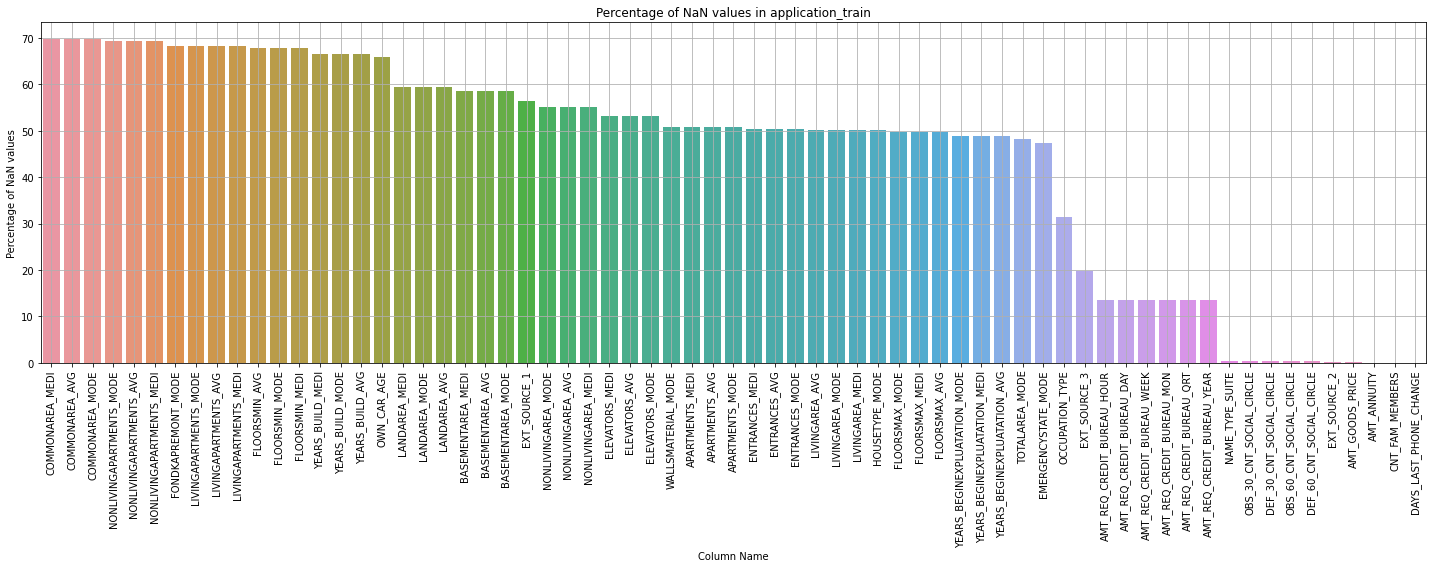

In [16]:
plot_nan_percent(nan_df_create(application_train), 'application_train', grid = True)

__NAN application_train.csv:__

> On peut voir sur le graphique ci-dessus qu'il y a 67 colonnes sur 122 caractéristiques qui contiennent des valeurs NaN. S'il n'y avait qu'une ou deux colonnes qui avaient des valeurs NaN, nous aurions pu nous en tirer en éliminant simplement ces colonnes, mais pour un si grand nombre de colonnes, nous ne pouvons pas les supprimer telles quelles, car la perte d'informations pourrait être très élevée.
>
> Nous voyons que certaines colonnes comme relatives à "COMMONAREA", "NONLIVINAPARTMENT", etc. ont près de 70% de valeurs manquantes. Nous devrons trouver des techniques pour gérer ces nombreuses valeurs manquantes et voir ce qui fonctionnerait le mieux pour nos données.
>
> Une autre chose à noter ici est que la plupart des colonnes qui ont plus de 50% de valeurs manquantes sont liées aux statistiques des appartements de l'emprunteur. Il est très probable que ces valeurs n'aient pas été enregistrées lors de la saisie des données et pourraient être facultatives.

## Test Data

In [17]:
print('-'*100)
print(f'The shape of application_test.csv is: {application_test.shape}')
print('-'*100)
print(f'Number of duplicate values in application_test: {application_test.shape[0] - application_test.duplicated().shape[0]}')
print('-'*100)
display(application_test.head())

----------------------------------------------------------------------------------------------------
The shape of application_test.csv is: (48744, 121)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_test: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.00,568800.00,20560.50,450000.00,Unaccompanied,Working,Higher education,Married,House / apartment,0.02,-19241,-2329,-5170.00,-812,nan,1,1,0,1,0,1,NaN,2.00,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.75,0.79,0.16,0.07,0.06,0.97,nan,nan,nan,0.14,0.12,nan,nan,nan,0.05,nan,nan,0.07,0.06,0.97,nan,nan,nan,0.14,0.12,nan,nan,nan,0.05,nan,nan,0.07,0.06,0.97,nan,nan,nan,0.14,0.12,nan,nan,nan,0.05,nan,nan,NaN,block of flats,0.04,"Stone, brick",No,0.00,0.00,0.00,0.00,-1740.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
1,100005,Cash loans,M,N,Y,0,99000.00,222768.00,17370.00,180000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-18064,-4469,-9118.00,-1623,nan,1,1,0,1,0,0,Low-skill Laborers,2.00,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.56,0.29,0.43,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,3.00
2,100013,Cash loans,M,Y,Y,0,202500.00,663264.00,69777.00,630000.00,NaN,Working,Higher education,Married,House / apartment,0.02,-20038,-4458,-2175.00,-3503,5.00,1,1,0,1,0,0,Drivers,2.00,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,nan,0.70,0.61,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00,0.00,0.00,0.00,-856.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,4.00
3,100028,Cash loans,F,N,Y,2,315000.00,1575000.00,49018.50,1575000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.03

__application_test.csv:__
>
> Le fichier application_test.csv contient environ 48,7k (48 700) enregistrements et 121 features (colonnes).\ 
> Ces features sont exactement celles qui se trouvent dans application_train.csv, sauf qu'il s'agit des ensembles d'apprentissage (d'entrainement).\
> Il y a 48,7k __SK_ID_CURR__ uniques qui représentent des demandes de prêt uniques.\
> La colonne __TARGET__ a été omise et doit être prédite à l'aide de modèles statistiques prédictifs et d'apprentissage automatique.


### Test Data : NaN Columns and Percentages

Number of columns having NaN values: 64 columns


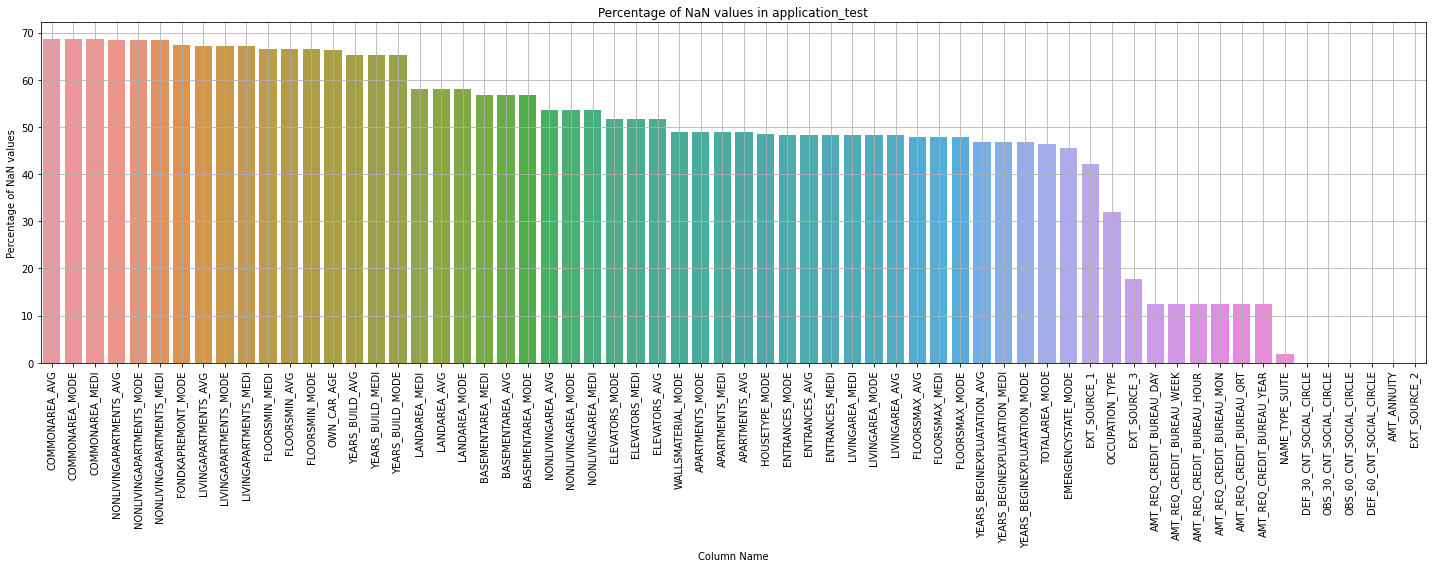

In [18]:
plot_nan_percent(nan_df_create(application_test), 'application_test', grid = True)

__NAN application_test.csv:__

> Il y a un nombre très similaire de colonnes avec des valeurs NaN (64) comme avec application_train.
Les pourcentages de valeurs NaN sont également assez similaires à ceux présents dans l'ensemble de données d'apprentissage. Cela signifie que les ensembles d'entraînement et de test sont à peu près de distribution similaire.

## Distribution of Target Variable

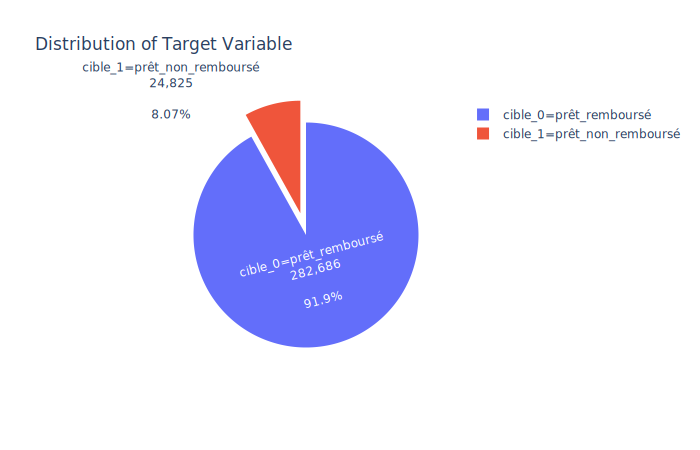

In [19]:
target_distribution = application_train.TARGET.value_counts()
#labels = ['Non-Defaulter', 'Defaulter']
labels = ['cible_0=prêt_remboursé', 'cible_1=prêt_non_remboursé']
#La valeur "0" = 'Non-Defaulter' signifie que le prêt est remboursé,
#la valeur "1" = 'Defaulter' signifie que le prêt n'est pas remboursé.

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textinfo = 'label+percent+value' , pull = [0,0.20])], 
         layout = go.Layout(title = 'Distribution of Target Variable'))

fig.show(renderer = 'svg')

__Observations et conclusions :__
> À partir de la distribution de la variable cible, une chose que nous pouvons rapidement remarquer est le __déséquilibre des données__.
> Il n'y a que 8,07 % du total des prêts qui ont effectivement été en défaut. Cela signifie que les défaillants sont la classe minoritaire.
> D'autre part, il y a 91,9% de prêts qui n'ont pas été en défaut. Ainsi, les Non-Defaulters/'cible_0=prêt_remboursé' seront notre classe majoritaire.
> Les défaillants ont reçu une variable cible de 1 et les non-défauts ont reçu une variable cible 0.
>
>
> __Pour les jeux de données déséquilibrés__, lors de la construction du modèle, nous ne pouvons pas alimenter les données telles quelles à certains algorithmes, qui sont sensibles aux déséquilibres.
> C'est le cas avec les mesures de performance. Pour un tel ensemble de données, la précision n'est généralement pas __la bonne mesure__ car __la précision__ serait généralement biaisée en faveur de la classe majoritaire. Nous pouvons utiliser d'autres métriques telles que le __score ROC-AUC (ROC-AUC Score)__, le __Log-Loss__, le __score F1 (F1-Score)__, la __matrice de confusion (Confusion Matrix)__ pour une meilleure évaluation du modèle.
>
> Une autre chose importante à noter ici est qu'il y a très peu de gens qui font réellement défaut, et ils ont tendance à montrer une sorte de comportement différent. Ainsi, dans de tels cas de fraude, de défaut et de détection d'anomalies, nous devons également nous concentrer sur les valeurs aberrantes et nous ne pouvons pas les supprimer, car elles pourraient être le facteur de différenciation entre défaillant et non défaillant.

## Phi-K matrix (matrice de corrélation de caractéristiques catégorielles)

> Nous allons tracer une carte thermique des valeurs du coefficient de corrélation Phi-K entre chacune des caractéristiques avec l'autre.\
> Le coefficient Phi-K est similaire au coefficient de corrélation, sauf qu'il peut être utilisé avec une paire de caractéristiques catégorielles pour vérifier si une caractéristique présente une sorte d'association avec l'autre caractéristique catégorielle. \
> Sa valeur maximale peut être 1, ce qui montrerait une association maximale entre deux variables catégorielles.

----------------------------------------------------------------------------------------------------


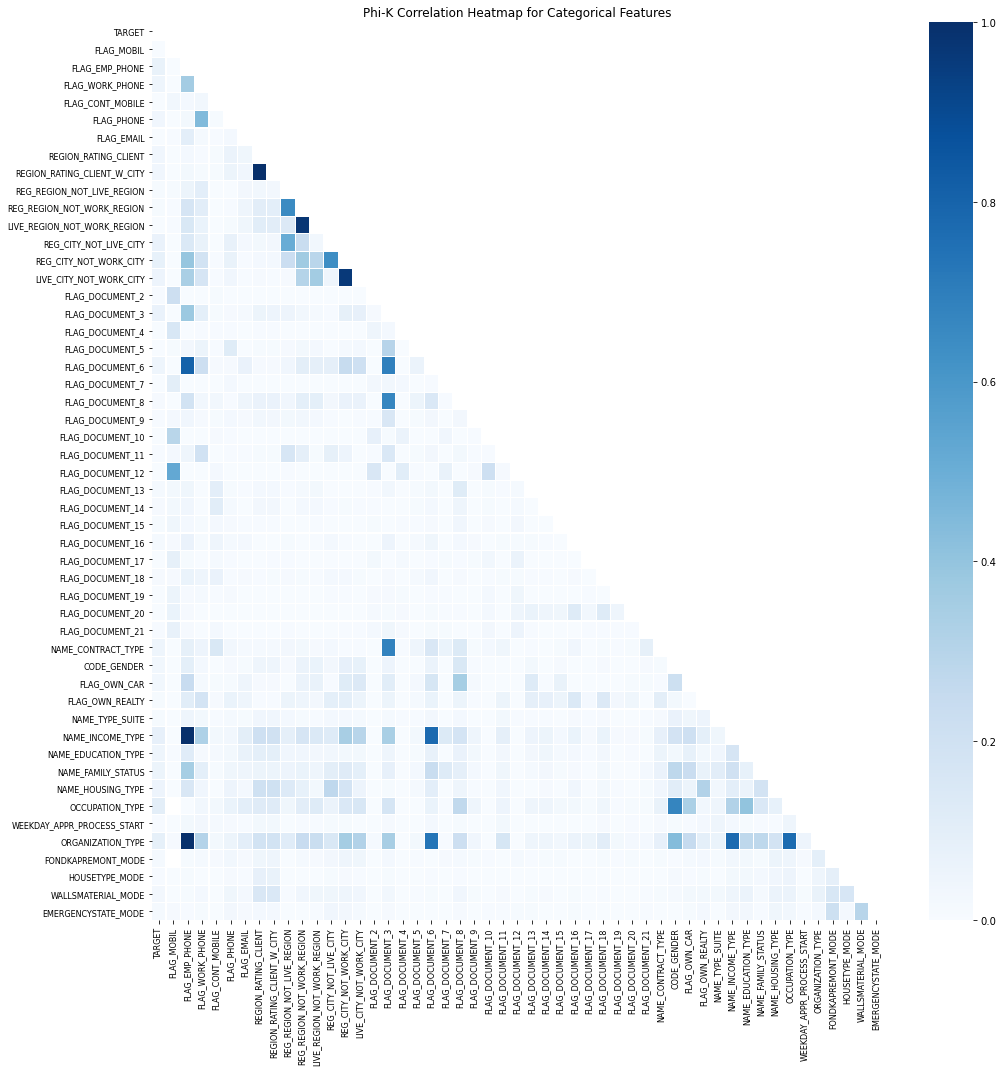

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.10
45,ORGANIZATION_TYPE,0.09
39,NAME_INCOME_TYPE,0.08
12,REG_CITY_NOT_WORK_CITY,0.08
1,FLAG_EMP_PHONE,0.07
11,REG_CITY_NOT_LIVE_CITY,0.07
15,FLAG_DOCUMENT_3,0.07
41,NAME_FAMILY_STATUS,0.06
42,NAME_HOUSING_TYPE,0.05
13,LIVE_CITY_NOT_WORK_CITY,0.05


----------------------------------------------------------------------------------------------------


In [20]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + application_train.dtypes[
                                    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns, figsize = (15,15), fontsize = 8)

__Observations et conclusions :__

> À partir de la carte thermique ci-dessus de la corrélation Phi-K, nous voyons que la plupart des caractéristiques catégorielles ne sont pas corrélées les unes aux autres, mais certaines d'entre elles présentent une forte corrélation.

> Certaines des paires de catégories hautement corrélées sont :
    REGION_RATING_CLIENT_W_CITY et REGION_RATING_CLIENT - Ceci est compréhensible car ils raconteraient plus ou moins une histoire similaire.
    LIVE_REGION_NOT_WORK_REGION et REG_REGION_NOT_WORK_REGION
    NAME_INCOME_TYPE, ORGANIZATION_TYPE et FLAG_EMP_PHONE

> Nous pouvons également voir une certaine corrélation entre le type d'organisation et le type de revenu d'un client. 
> De même, nous voyons une corrélation entre le type d'occupation et le type d'organisation aussi.

> Nous constatons que la catégorie OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY sont parmi les catégories les plus corrélées avec la variable TARGET. > > > Ceux-ci peuvent être importants dans la tâche de classification et nécessiteraient une EDA supplémentaire

## Correlation Matrix de Features (matrice de corrélation de caractéristiques numériques)

----------------------------------------------------------------------------------------------------


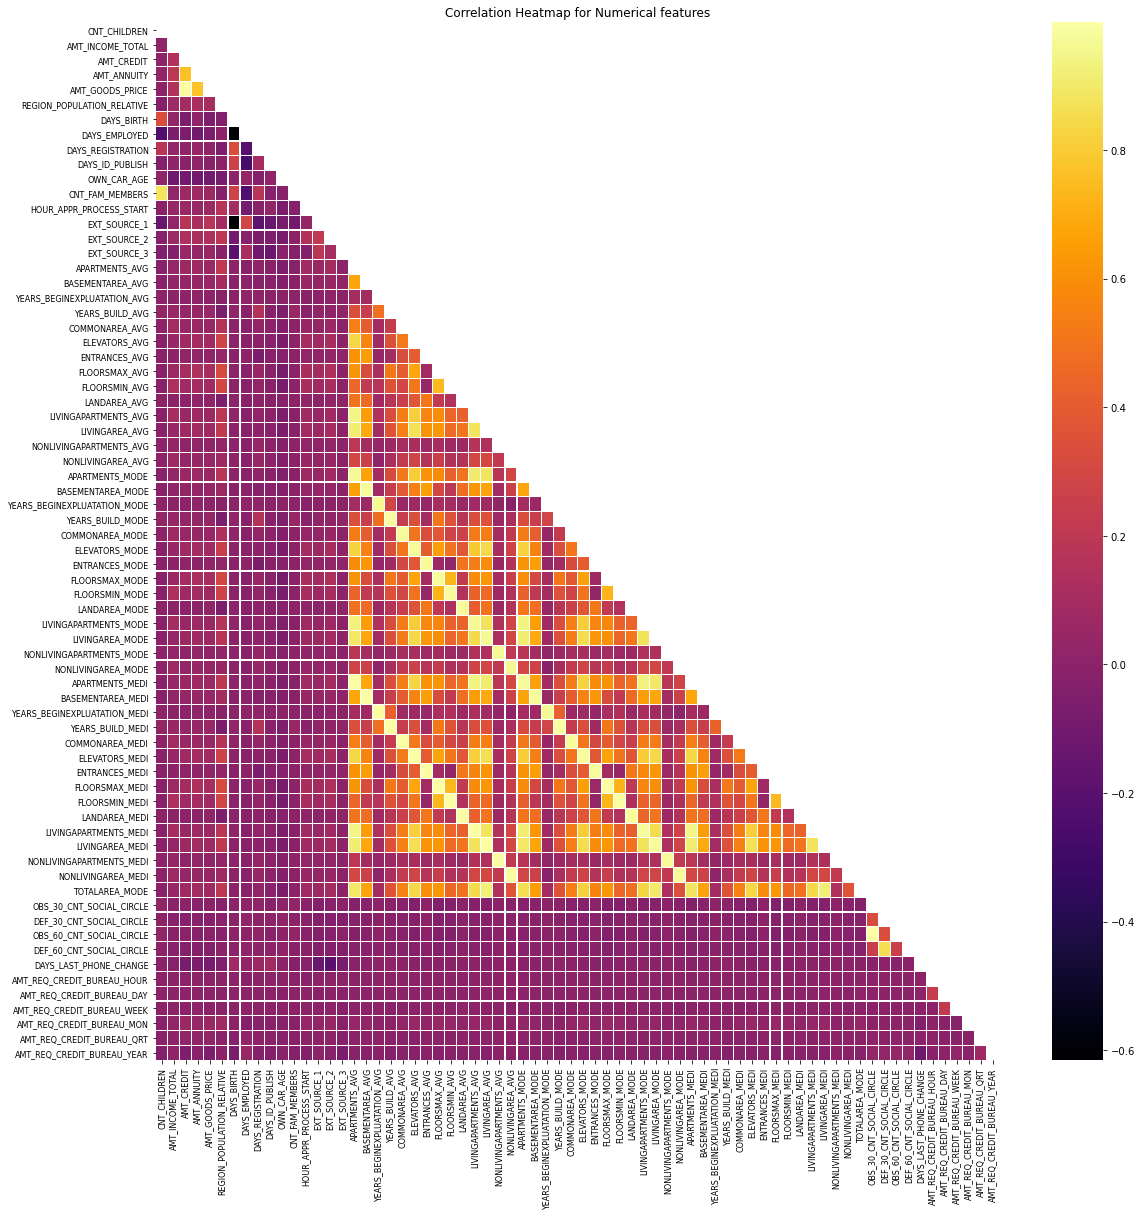

----------------------------------------------------------------------------------------------------


In [21]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [22]:
#Seeing the top columns with highest phik-correlation with the target variable in application_train table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

,Column Name,Phik-Correlation
15,EXT_SOURCE_3,0.25
13,EXT_SOURCE_1,0.22
14,EXT_SOURCE_2,0.21
6,DAYS_BIRTH,0.10
63,DAYS_LAST_PHONE_CHANGE,0.07
7,DAYS_EMPLOYED,0.07
9,DAYS_ID_PUBLISH,0.07
4,AMT_GOODS_PRICE,0.06
23,FLOORSMAX_AVG,0.06
51,FLOORSMAX_MEDI,0.06


----------------------------------------------------------------------------------------------------


__Observations et conclusions :__

> La carte thermique fait un bon travail pour montrer la valeur ou le niveau de corrélation que chaque caractéristique particulière a avec toutes les autres caractéristiques.

> On peut observer que la majeure partie de la carte thermique contient une couleur violette, ce qui indique une très petite valeur de corrélation. Cela implique que la plupart des caractéristiques ne sont en effet pas corrélées aux autres.

> Cependant, nous pouvons voir des nuances contrastées au milieu de la carte thermique. 
> Ces nuances représentent une valeur élevée de corrélation entre les caractéristiques.
> Ce sont les caractéristiques qui sont liées aux statistiques des appartements.
> Si nous regardons les fonctionnalités de application_train, nous pouvons clairement voir que les statistiques des appartements sont données en termes de moyenne, médiane et mode, on peut donc s'attendre à ce que la moyenne, la médiane et le mode soient corrélés les uns aux autres. 
> Une autre chose à noter est que les caractéristiques d'une catégorie particulière, par exemple la moyenne, sont également corrélées avec d'autres caractéristiques moyennes, telles que le nombre d'ascenseurs, la superficie habitable, la superficie non habitable, la superficie du sous-sol, etc.

> Nous constatons également une forte corrélation entre AMT_GOODS_PRICE et AMT_CREDIT, entre DAYS_EMPLOYED et DAYS_BIRTH.
> Nous ne voudrions pas de features fortement corrélées car elles augmentent la complexité temporelle du modèle sans lui ajouter beaucoup de valeur. 
> Par conséquent, nous supprimerions les caractéristiques inter-corrélées.
> Parmi toutes les features, nous voyons une forte corrélation pour les features EXT_SOURCE par rapport à la variable cible. Ceux-ci pourraient être importants pour notre tâche de classification.
>

## Tracé des variables catégorielles

### critère : type de contrat de prêt

In [23]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(application_train, 'NAME_CONTRACT_TYPE')

#plotting the Pie Plot for the column
plot_categorical_variables_pie(application_train, 'NAME_CONTRACT_TYPE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


__Observations et conclusions :__

> À partir du graphique ci-dessus, nous pouvons tirer les observations et conclusions suivantes :

> A partir de la première à gauche, c'est-à-dire la distribution globale :
On peut voir que la plupart des prêts contractés par les clients sont des prêts de trésorerie en espèces.
> Seulement 9,52 % des gens ont pris des prêts renouvelables.

> À partir de la deuxième à droite, c'est-à-dire le pourcentage de défaillants :
> Nous voyons qu'il y a plus de pourcentage de personnes qui ont fait défaut avec les prêts de trésorerie en espèces (8,35%) par rapport à celles qui ont fait défaut avec les prêts renouvelables (5,48%).

### critère : genre Male/Femelle

In [24]:
#let us first see the unique categories of 'CODE_GENDER'
print_unique_categories(application_train, 'CODE_GENDER', show_counts = True)

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, 'CODE_GENDER', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


__Observations et conclusions :__
La fonctionnalité Distribution de CODE_GENDER semble intéressante. Voici quelques points de discussion :

> Le premier point à observer est qu'il y a 4 lignes dans la table application_train qui ont des genres 'XNA', qui n'ont pas beaucoup de sens, et peuvent être comptées comme des valeurs NaN. Puisqu'ils ne sont que 4 en nombre et n'appartiennent qu'à la catégorie non par défaut. Ainsi, nous pouvons éliminer ces rangées sans trop d'hésitation.

> À partir de la sous-parcelle 1, nous voyons que pour l'ensemble de données donné, il y a plus de femmes candidates (65,8%) que d'hommes (34,2%).

> Cependant, contrairement au nombre de femmes candidates, à partir du deuxième graphique, nous notons qu'il a été constaté que les candidats masculins ont tendance à être plus défaillants (10,14 %) que les candidates (7 %).

> Ainsi, on peut dire que les hommes ont plus tendance à faire défaut que les femmes selon l'ensemble de données donné.

### critère : Phone number

In [25]:
#let us first see the unique categories of 'FLAG_EMP_PHONE'
print_unique_categories(application_train, 'FLAG_EMP_PHONE')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'FLAG_EMP_PHONE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


__Observations et conclusions :__
Cette fonctionnalité contient deux catégories, c'est-à-dire si le client a fourni ou non son numéro de téléphone professionnel lors du processus d'inscription/de demande.

À partir de la première sous-intrigue, nous voyons que la plupart des candidats ne fournissent pas leur numéro de téléphone professionnel (82 %) et que seuls 18 % ont fourni leur numéro de téléphone professionnel.
On peut également voir que la tendance par défaut pour ceux qui fournissent un numéro de téléphone professionnel est plus élevée que pour ceux qui ne fournissent pas de numéro de téléphone professionnel.
Cette caractéristique pourrait être attribuée au fait que les défaillants peuvent fournir leurs numéros de téléphone au travail afin qu'ils ne soient pas dérangés sur leur téléphone personnel.

### critère : Région client

Cette caractéristique est la note fournie par Home Credit à la région de chaque client en fonction des sondages qu'ils ont pu effectuer. Cette note prend également en compte la Ville dans laquelle réside le client.
Il est important de tenir compte de la ville car même si certaines régions ont une bonne note dans une ville en particulier, mais que cette ville n'a pas une note élevée, le candidat recevra une note moyenne et non une note élevée.
Il contient des valeurs comprises entre 1 et 3.

In [26]:
#let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
print_unique_categories(application_train, 'REGION_RATING_CLIENT_W_CITY')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'REGION_RATING_CLIENT_W_CITY')
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


__Observations et conclusions :__
À partir des graphiques ci-dessus, nous pouvons tirer les enseignements suivants :

> Dès la première sous-intrigue, nous voyons que la plupart des clients (74,6%) ont une note de région de 2. Il s'agit de la valeur moyenne qui correspond à la plupart des candidats.
Très peu de candidats ont une note régionale de 1 (seulement 11,1%) et certains ont une note de 3 (14,3%).

> Parmi les défaillants, on constate que la plupart des défaillants ont une note régionale de 3 (11,4%) qui est comparativement plus élevée que les deux autres notes, c'est-à-dire que les clients avec une note de 1 ont un pourcentage de défaut de seulement 4,84% et avec une note de 2 ont un pourcentage de 7,92 %.

> Cela montre que la notation 3 pourrait être un attribut important pour prendre une décision sur les caractéristiques de défaut.

### critère : Education achevée le plus élevée

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


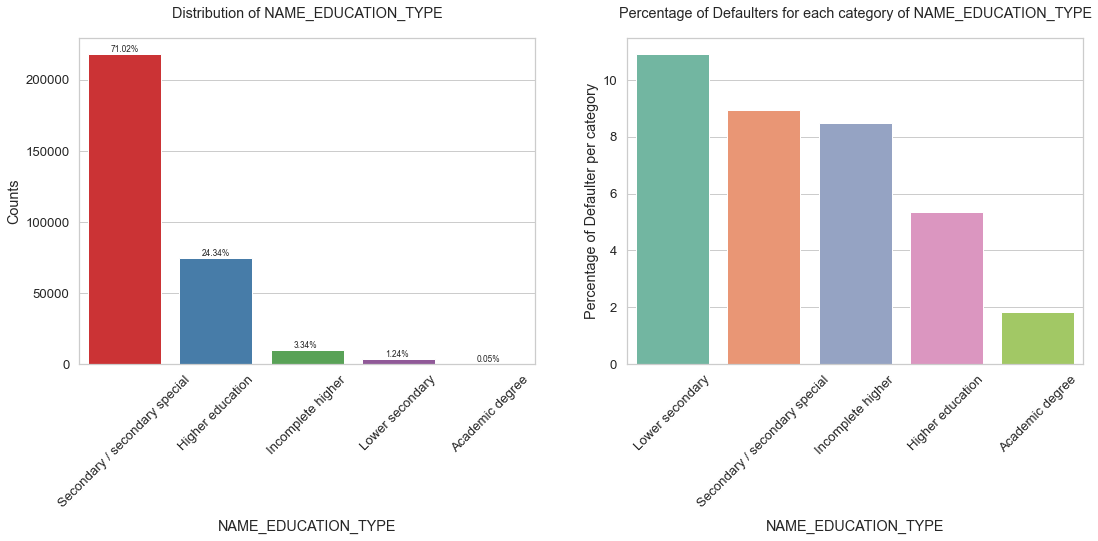

----------------------------------------------------------------------------------------------------


In [27]:
#let us first see the unique categories of 'NAME_EDUCATION_TYPE'
print_unique_categories(application_train, 'NAME_EDUCATION_TYPE', show_counts = True)

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)
print('-'*100)

__Observations et conclusions :__
En regardant les graphiques ci-dessus, nous pouvons conclure ce qui suit :

> Environ 71% des personnes n'ont fait leurs études que jusqu'au secondaire/secondaire spécial, ainsi que 24,34% des clients ayant fait des études supérieures. Cela suggère que la plupart des clients/emprunteurs n'ont pas un niveau d'éducation élevé.

> À partir du deuxième graphique, nous voyons que les personnes qui ont fait leurs études jusqu'au premier cycle du secondaire seulement ont les caractéristiques de défaut les plus élevées, les secondaires et incomplets ayant des tendances de défaut similaires.

> Le groupe de personnes ayant fait des études supérieures a une tendance à l'échec comparativement plus faible, ce qui est également logique. De plus, les personnes ayant un diplôme universitaire affichent le taux de défaut le moins élevé. Cependant, le groupe Diplôme universitaire est très peu nombreux, il pourrait donc ne pas être très utile.

### critère : Emploi/Métier exercé par le client

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


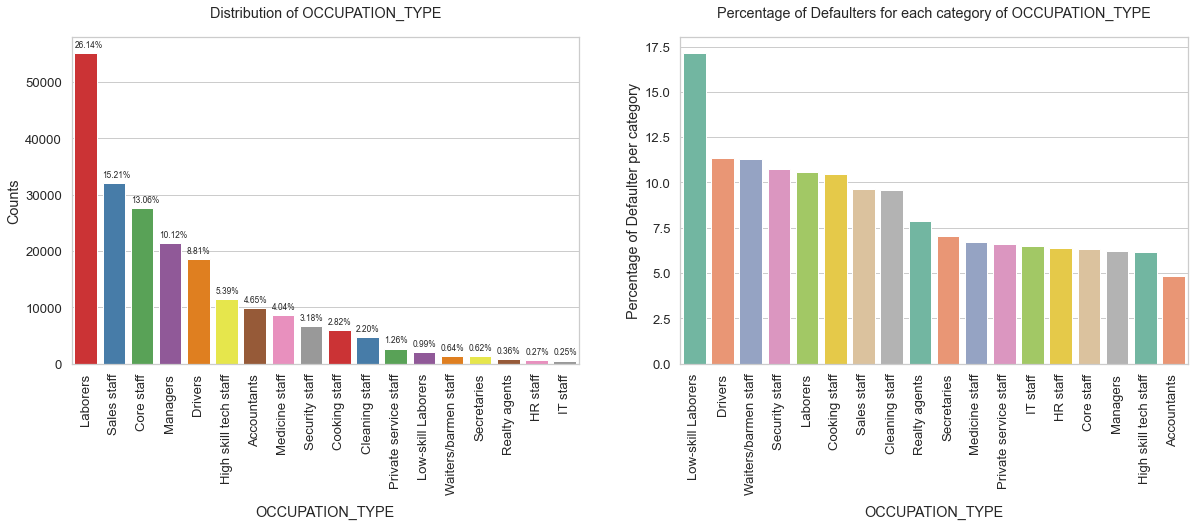

----------------------------------------------------------------------------------------------------


In [28]:
#let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(application_train, 'OCCUPATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

__Observations et conclusions :__
A partir des graphiques du type d'occupation, nous pouvons tirer les observations suivantes :

> Parmi les candidats, le type d'occupation le plus courant est celui des manœuvres, contribuant à près de 26 % des candidatures. La deuxième profession la plus fréquente est le personnel de vente, suivi du personnel de base et des gestionnaires.

> Le taux de défaut des ouvriers peu qualifiés est le plus élevé parmi tous les types de professions (~ 17,5 %). Viennent ensuite les chauffeurs, les serveurs, le personnel de sécurité, les ouvriers, le personnel de cuisine, etc. Tous les emplois sont des emplois de bas niveau. Cela montre que les personnes à faible niveau d'emploi ont tendance à avoir un taux de défaut plus élevé.

> Les taux de défaut les plus bas se trouvent parmi les comptables, le personnel de base, les gestionnaires, le personnel technique hautement qualifié, le personnel des ressources humaines, etc., qui appartiennent à des emplois de niveau moyen à élevé.

> Ainsi, on peut conclure que les travailleurs de bas niveau ont tendance à avoir une tendance à la défaillance plus élevée que les emplois de niveau moyen-élevé.

### critère : Employeur du client

Total Number of categories of ORGANIZATION_TYPE = 58


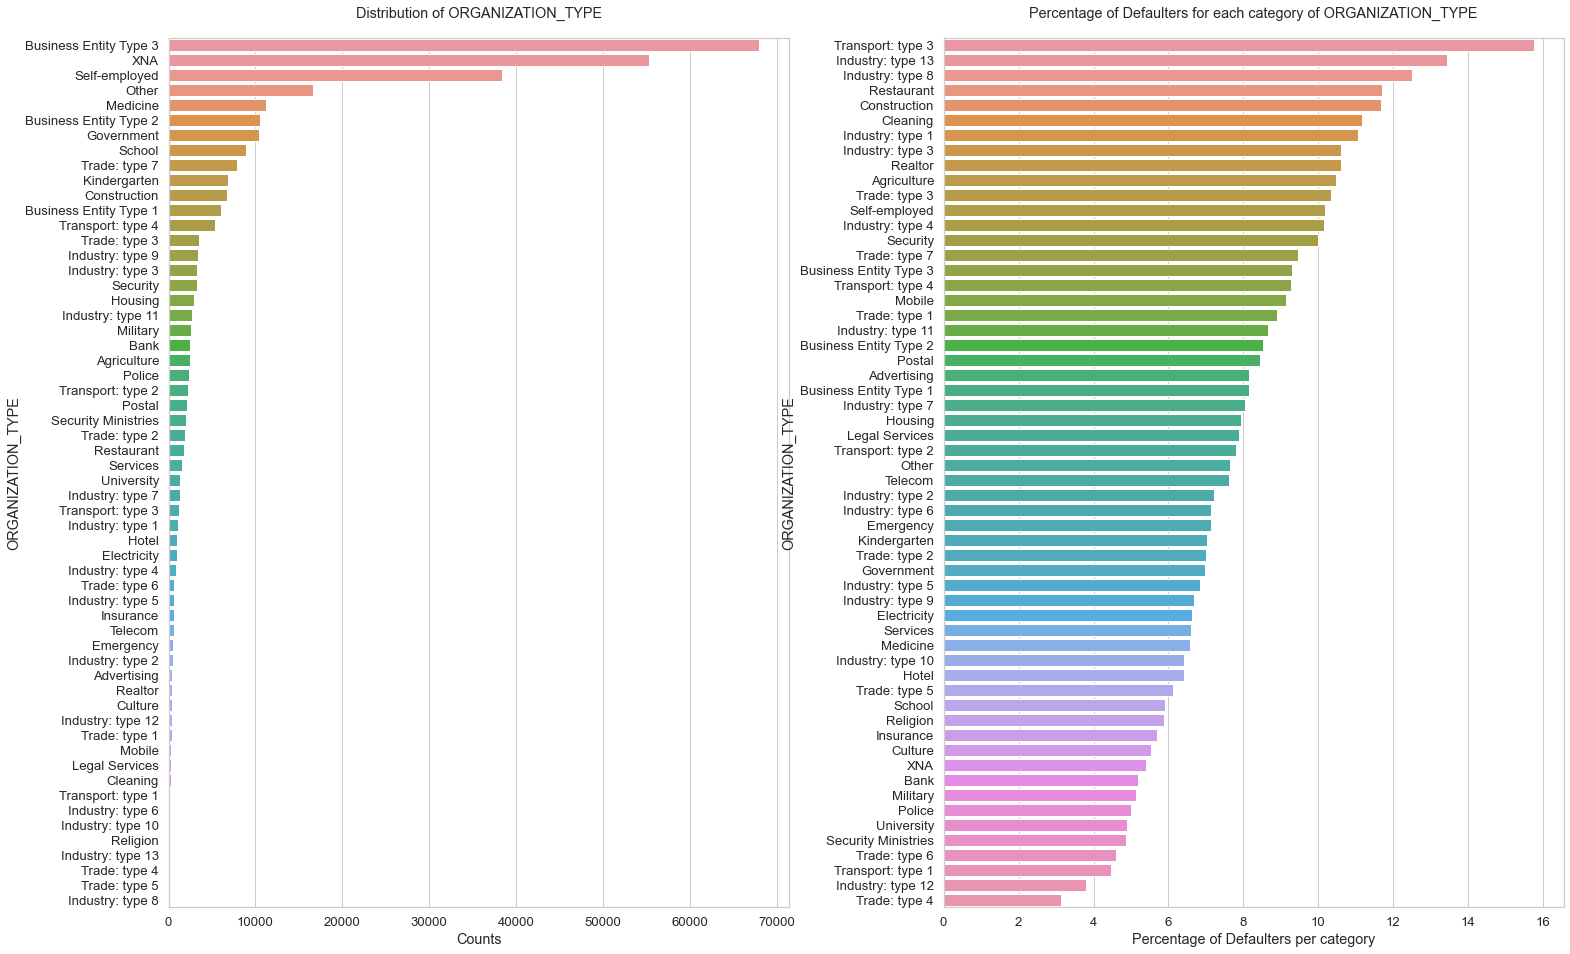

In [29]:
print(f"Total Number of categories of ORGANIZATION_TYPE = {len(application_train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize = (25,16))
sns.set(style = 'whitegrid', font_scale = 1.2)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
count_organization = application_train.ORGANIZATION_TYPE.value_counts().sort_values(ascending = False)
sns.barplot(x = count_organization, y = count_organization.index)
plt.title('Distribution of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

plt.subplot(1,2,2)
percentage_default_per_organization = application_train[application_train.TARGET == 1].ORGANIZATION_TYPE.value_counts() * 100 / count_organization
percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending = False)
sns.barplot(x = percentage_default_per_organization, y = percentage_default_per_organization.index)
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

plt.show()

__Observations et conclusions :__
Il existe de nombreux types d'organisations auxquelles appartient le client, 58 pour être précis. Les graphiques ci-dessus donnent les observations suivantes :

> Dès le premier graphique, nous voyons que la plupart des candidats travaillent dans des organisations de type 'Business Entity Type3', 'XNA' ou 'Self Employed'. Le type d'organisation « XNA » pourrait probablement désigner un type d'organisation non classifié.

> A partir du deuxième graphique, nous remarquons que les demandeurs appartenant au 'Transport : type 3' ont la tendance à la défaillance la plus élevée par rapport au reste. Ils sont suivis d'organisations de types : 'Industrie : type 13', 'Industrie : type 8', 'Restaurant', 'Bâtiment', etc.

> Les organisations qui affichent les taux de défaut les plus bas sont « Commerce : type 4 », « Industrie : type 12 », etc.
Ces numéros de type diraient également quelque chose de plus sur l'Organisation, cependant, nous n'avons aucune information à ce sujet, nous nous en tiendrons donc à la dénomination qui nous est fournie uniquement.

### critère : domiciliation adresse région ou ville

REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY :
Ces colonnes incluent des indicateurs indiquant si l'adresse permanente du client correspond à son adresse de contact ou à son adresse professionnelle ou non au niveau de la région

LIVE_CITY_NOT_WORK_CITY Cette colonne indique si l'adresse permanente du client correspond ou non à son adresse de contact au niveau de la ville.

__Ici, 1 indique des adresses différentes et 0 indique les mêmes adresses.__

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


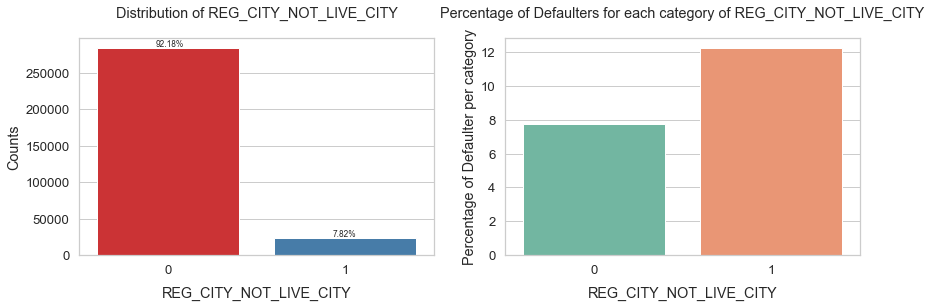

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


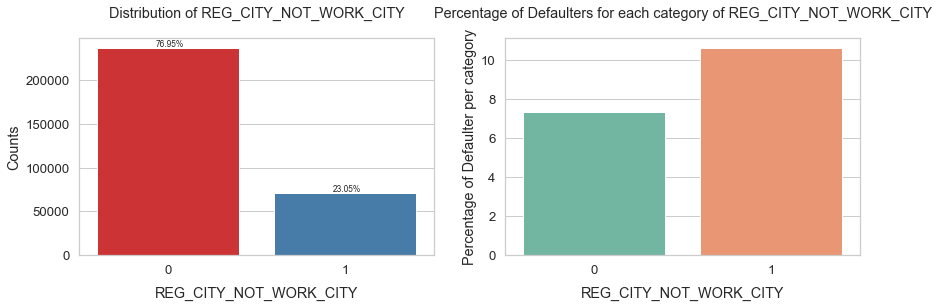

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


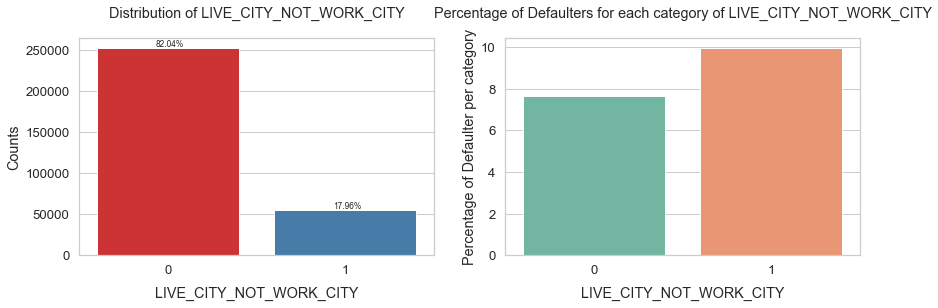

----------------------------------------------------------------------------------------------------


In [30]:
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)

__Observations et conclusions :__
À partir des 3 graphiques ci-dessus, les informations suivantes peuvent être tirées :

> De tous les candidats, il n'y a qu'une minorité de candidats dont les adresses ne correspondent pas.

> Premièrement, il n'y a que 7,52 % de personnes qui ont une adresse permanente différente de leur adresse de contact au niveau régional.

> Deuxièmement, il y a environ 23,05 % de personnes qui ont une adresse permanente différente de leur adresse de travail au niveau régional. Ce nombre plus élevé s'explique, car il est possible qu'ils travaillent dans une région différente par rapport à leur adresse permanente.

> Enfin, il y a environ 17,96 % de personnes qui ont une adresse permanente différente de leur adresse de contact au niveau de la ville.

> Si nous examinons les caractéristiques par défaut, nous constatons qu'il existe une tendance maximale au défaut de ces personnes qui ont leurs adresses permanente et de contact différentes au niveau de la région, qui est suivie par une adresse permanente et professionnelle différente et enfin une adresse permanente et de contact différente au niveau de la ville .

> Pour tous les cas, on constate que la tendance au défaut de ces personnes qui ont des adresses différentes est plus élevée que celles qui ont la même adresse. Cela signifie que quelque part, cette différence d'adresse peut suggérer un risque de défaut.

### critère : pièces jointes (dossier complèt : oui/non)

Cette colonne contient le drapeau concernant un document qui devait être soumis par le demandeur. Sa valeur est 0 si le client a fourni le document et 1 sinon.

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


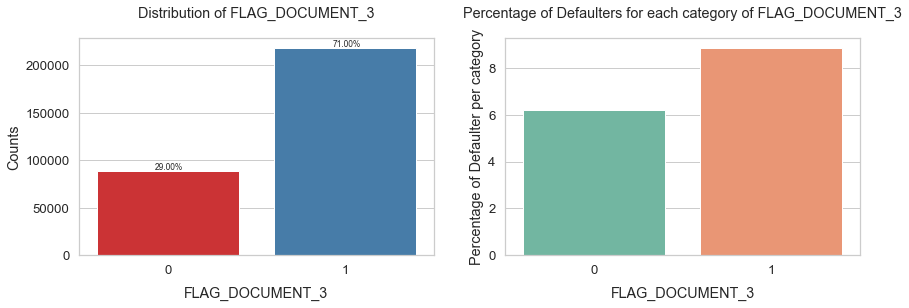

In [31]:
plot_categorical_variables_bar(application_train, column_name = 'FLAG_DOCUMENT_3', figsize = (14, 4), horizontal_adjust = 0.33)

__Observations et conclusions :__
D'après le graphique ci-dessus, nous voyons que :

> Dès la première intrigue secondaire, nous voyons que la plupart des clients n'avaient pas fourni ce document (~71 %) et seulement 29 % l'ont fait.

> À partir de la deuxième sous-intrigue, nous voyons que ceux qui avaient fourni ce document avaient un taux de défaut plus élevé que ceux qui ne l'avaient pas fait. Cela signifie que les candidats qui avaient fourni le Document_3 ont tendance à faire plus défaut que ceux qui ne le font pas.

> Peut-être que cela pourrait être lié au certificat BPL ou à quelque chose, mais nous n'avons pas reçu cette information, nous ne pouvons donc rien dire sur le type de document que cela aurait pu être.

## Tracé des variables continues (numériques)

### critère : Age

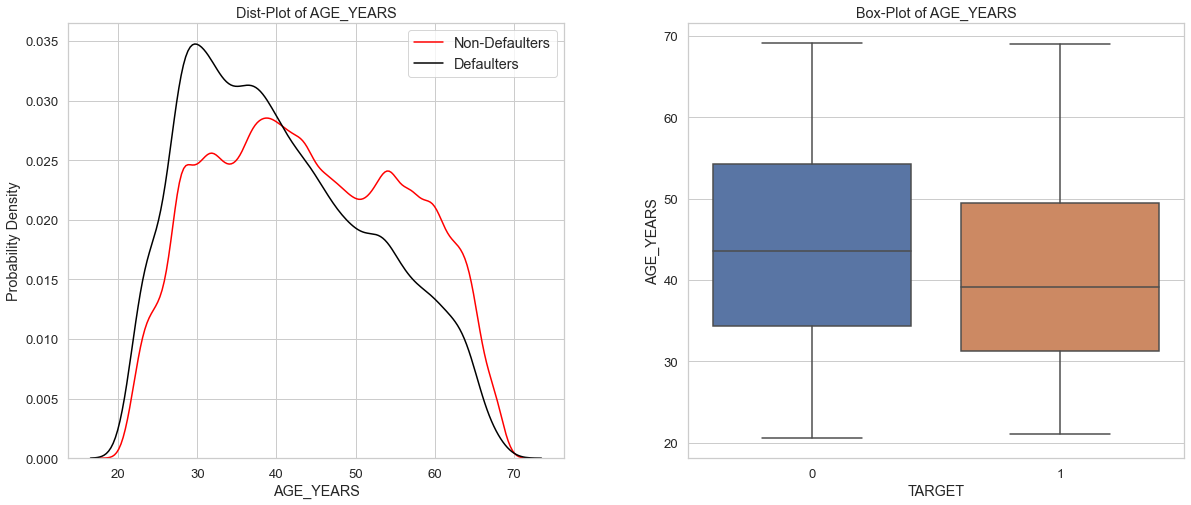

In [32]:
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(application_train, 'AGE_YEARS', plots = ['distplot','box'])
_ = application_train.pop('AGE_YEARS')

__Observations et conclusions :__
À partir des deux graphiques ci-dessus, nous pouvons tirer des informations importantes.

> À partir de la distribution, nous pouvons observer le pic d'âge des personnes par défaut à près de 30 ans. De plus, à ce stade, les non-défauts ont un PDF assez petit. Une autre chose à noter est que le PDF de Age for Defaulters commence un peu à gauche des non-Defaulters, et est également un peu dans toute la gamme. Cela signifie que les défaillants sont généralement plus jeunes que les non-défauts.

> De CDF aussi, nous voyons que la probabilité

> A partir du box-plot aussi, on peut mieux visualiser la même chose. L'âge des défaillants est généralement inférieur à celui des non-défauts. Tous les quantiles d'âge des défaillants sont inférieurs à ceux des non-défauts. La valeur du 75e centile des non-défauts (0) est d'environ 54 ans tandis que pour les défaillants, elle est proche de 49 ans.

> Ces observations impliquent que les défaillants sont généralement plus jeunes que les non défaillants.

### critère : Ancienneté (temps passé sans chomâge)

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_EMPLOYED is -17912.0
The 25th percentile value of DAYS_EMPLOYED is -2760.0
The 50th percentile value of DAYS_EMPLOYED is -1213.0
The 75th percentile value of DAYS_EMPLOYED is -289.0
The 90th percentile value of DAYS_EMPLOYED is 365243.0
The 92th percentile value of DAYS_EMPLOYED is 365243.0
The 94th percentile value of DAYS_EMPLOYED is 365243.0
The 96th percentile value of DAYS_EMPLOYED is 365243.0
The 98th percentile value of DAYS_EMPLOYED is 365243.0
The 100th percentile value of DAYS_EMPLOYED is 365243.0
----------------------------------------------------------------------------------------------------


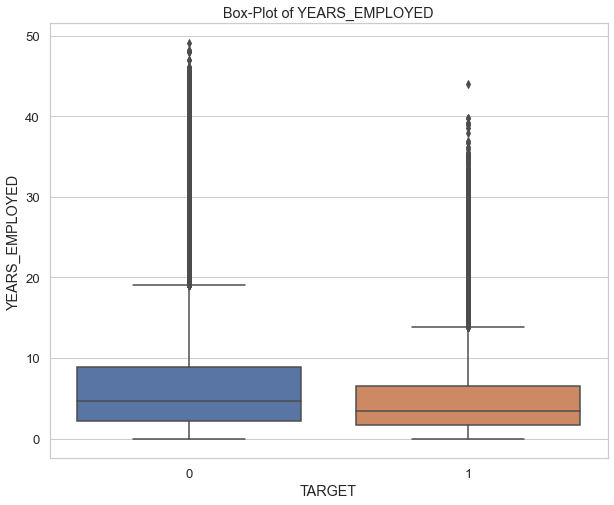

In [33]:
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365
print_percentiles(application_train, 'DAYS_EMPLOYED')
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))
_ = application_train.pop('YEARS_EMPLOYED')

__Observations et conclusions :__

> Nous voyons que la colonne DAYS_EMPLOYED contient des points de données erronés avec des valeurs 365243. Ceux-ci semblent être des valeurs erronées/non sensibles.

> À partir de la boîte à moustaches, nous observons que les défaillants semblent avoir moins d'années d'emploi que les non-défaillants. Tous les 25e, 50e et 75e quantiles pour les défaillants sont inférieurs à ceux des non-défauts.

### critère : Modif pièce d'identité

Cette colonne indique combien de jours après le jour de l'enregistrement le client a changé sa pièce d'identité avec laquelle il a demandé un prêt.

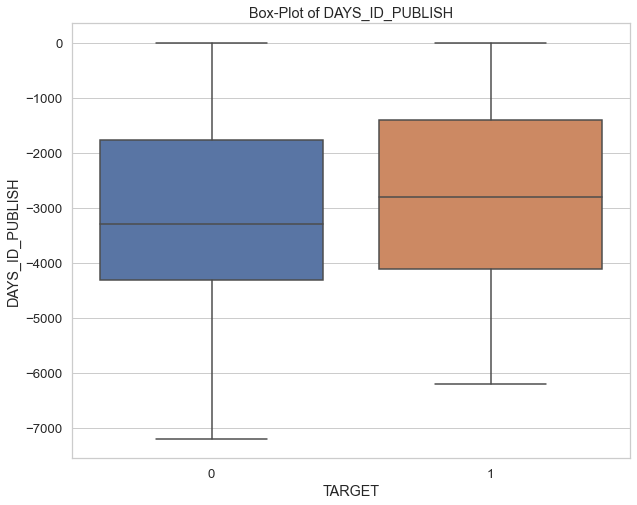

In [34]:
plot_continuous_variables(application_train, 'DAYS_ID_PUBLISH', plots = ['box'], figsize = (10,8))

__Observations et conclusions :__

> À partir de la boîte à moustaches ci-dessus, nous voyons une tendance similaire à celle observée avec DAYS_REGISTRATION, dans laquelle les défaillants avaient généralement moins de jours depuis qu'ils ont changé d'identité. Les Non-Defaulters montrent avoir plus de nombre de jours pour tous les quantiles depuis qu'ils ont changé leur pièce d'identité.

### critère : EXT_SOURCES/score

Il y a trois colonnes EXT_SOURCES, qui contiennent des valeurs entre 0 et 1. Ce sont des scores normalisés de différentes sources

----------------------------------------------------------------------------------------------------


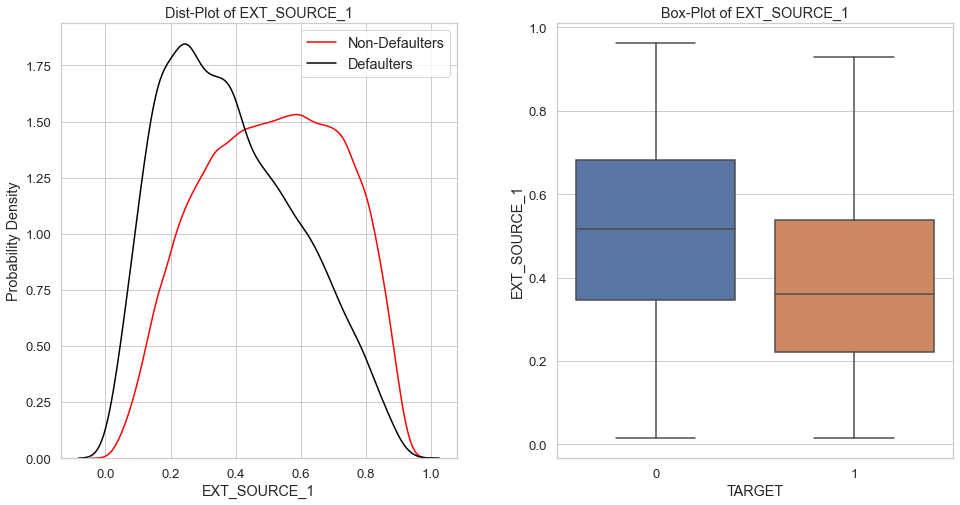

----------------------------------------------------------------------------------------------------


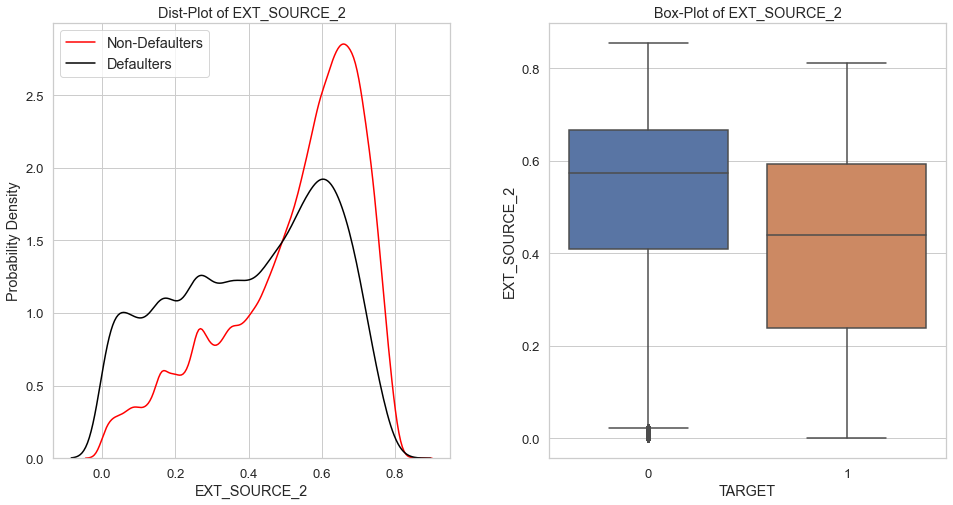

----------------------------------------------------------------------------------------------------


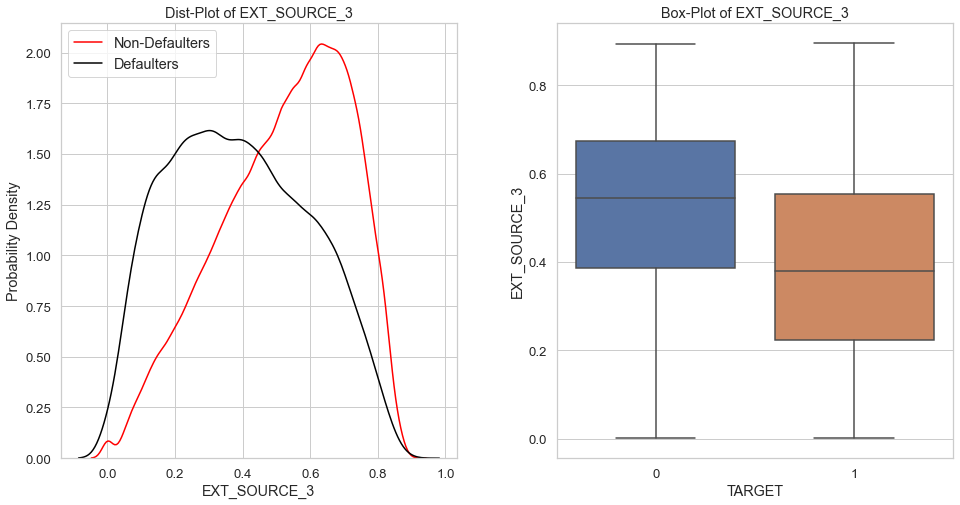

----------------------------------------------------------------------------------------------------


In [35]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)

__Observations et conclusions :__
Des trois graphiques ci-dessus, nous pouvons tirer les conclusions suivantes :

> Si nous regardons les box-plots, nous pouvons clairement voir une tendance similaire pour les trois colonnes EXT_SOURCE, à savoir que les défaillants ont tendance à avoir des valeurs considérablement plus faibles.

> Cette tendance peut également être observée avec les PDF. Les non-défauts montrent un pic plus élevé aux valeurs EXT_SOURCE élevées, et les densités de probabilité sont très faibles pour les valeurs faibles. Cela implique que les non-défauts ont généralement des valeurs élevées de ces scores.

> Il est intéressant de noter que la valeur médiane des défaillants est presque égale ou inférieure aux valeurs du 25e centile des non défaillants.
Les colonnes EXT_SOURCE_1 et EXT_SOURCE_3 ont tendance à montrer une meilleure discrimination/séparabilité par rapport à EXT_SOURCE_2.

> Ces 3 fonctionnalités semblent être la meilleure séparation linéaire entre les défauts et les non-défauts parmi toutes les fonctionnalités jusqu'à présent.

### critère : Nombre d'étage/batiment 

Ces colonnes décrivent les scores normalisés de la moyenne du nombre maximum et du mode minimum d'étages dans le bâtiment du demandeur

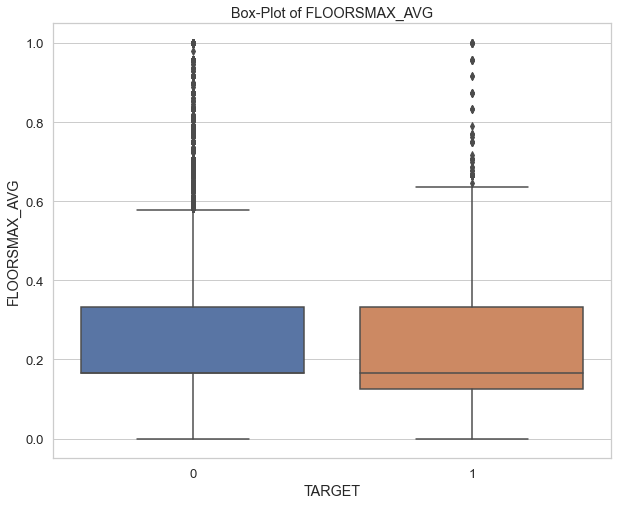

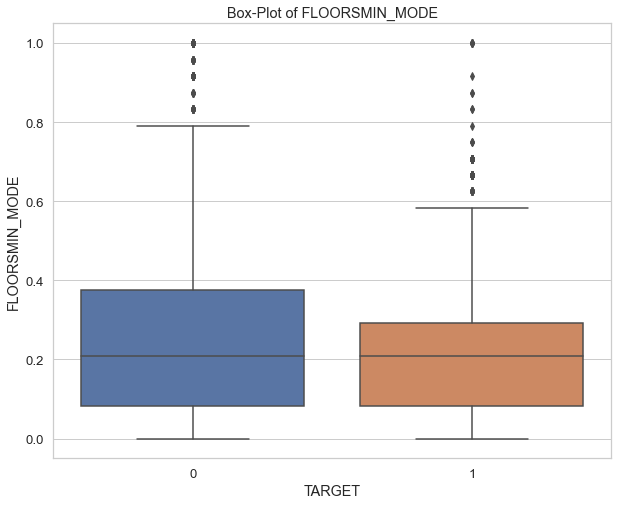

In [36]:
plot_continuous_variables(application_train, 'FLOORSMAX_AVG', plots = ['box'], figsize = (10,8))
plot_continuous_variables(application_train, 'FLOORSMIN_MODE', plots = ['box'], figsize = (10,8))

__Observations et conclusions__
À partir du graphique ci-dessus, nous pouvons tirer les enseignements suivants :

> Les défaillants ont une valeur médiane inférieure de la fonction FLOORSMAX_AVG par rapport aux non défaillants. Les valeurs du 75e centile des défaillants et des non défaillants sont plus ou moins les mêmes, mais la valeur du 25e centile des non défaillants est presque supérieure à la médiane des défaillants, ce qui pourrait donc être une caractéristique importante.

> Les non-défauts ont également tendance à afficher une valeur plus élevée de FLLORSMIN_MODE par rapport aux défaillants. La valeur du 75e centile des non-défauts est nettement plus élevée que la valeur du 75e centile des défaillants.

## Credit Bureau Data

Cette base comprend tous les dossiers de crédit antérieurs du client auprès d'institutions financières autres que Home Credit Group ; ils sont déclarés par le Credit Bureau.

In [37]:
print(f'The shape of bureau.csv is: {bureau.shape}')
print('-'*100)
print(f'Number of unique SK_ID_BUREAU in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Number of unique SK_ID_CURR in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')
print('-'*100)
display(bureau.head(5))

The shape of bureau.csv is: (1716428, 17)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau.csv are: 1716428
Number of unique SK_ID_CURR in bureau.csv are: 305811
Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: 263491
Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: 42320
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,nan,0,91323.00,0.00,nan,0.00,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.00,nan,nan,0,225000.00,171342.00,nan,0.00,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.00,nan,nan,0,464323.50,nan,nan,0.00,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.00,nan,nan,0.00,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,1197.00,nan,77674.50,0,2700000.00,nan,nan,0.00,Consumer credit,-21,nan


__Observations et conclusions :__

> Le fichier bureau.csv contient près de 1,7 million de points de données, avec 17 fonctionnalités. Sur ces 17 fonctionnalités, deux sont SK_ID_CURR et SK_ID_BUREAU.
SK_ID_BUREAU est l'identifiant du prêt précédent du client auprès d'autres institutions financières. Il peut y avoir plusieurs prêts antérieurs correspondant à un seul SK_ID_CURR qui dépend du modèle d'emprunt du client.

> SK_ID_CURR est l'ID de prêt du prêt actuel du client avec Home Credit.
Le reste des fonctionnalités contient d'autres statistiques telles que DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.

> Il y a 305 000 SK_ID_CURR uniques dans le bureau, dont :
Il y a 263k SK_ID_CURR dans le bureau qui sont présents dans application_train sur un total de 307k de SK_ID_CURR unique d'application_train. Cela signifie que certains des demandeurs en cours de demande de prêt auprès de Home Credit Group n'ont aucun antécédent de crédit auprès du service de crédit.

> De même, il y a 42,3k SK_ID_CURR dans le bureau qui sont présents dans application_test, sur un total de 48k de SK_ID_CURR unique d'application_test.

### Credit Bureau Data : NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 7 columns


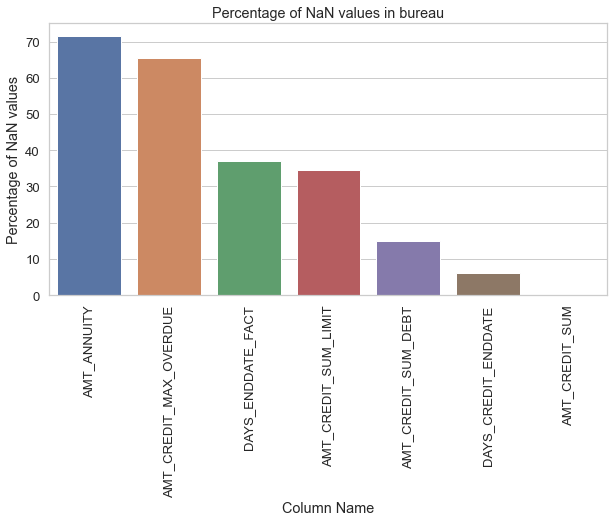

----------------------------------------------------------------------------------------------------


In [38]:
nan_df_bureau = nan_df_create(bureau)
print("-"*100)
plot_nan_percent(nan_df_bureau, 'bureau', tight_layout = False, figsize = (10,5))
print('-'*100)

__Observations et conclusions :__

> Sur 17 caractéristiques, il y a 7 caractéristiques qui contiennent des valeurs NaN.

> Les valeurs NaN les plus élevées sont observées avec la colonne AMT_ANNUITY qui a plus de 70% de valeurs manquantes.

### Fusion des TARGETS (des base de données : application_train + credit bureau).

In [39]:
print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = application_train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table
----------------------------------------------------------------------------------------------------


### Phi-K Matrix (matrice de corrélation de caractéristiques catégorielles)

----------------------------------------------------------------------------------------------------


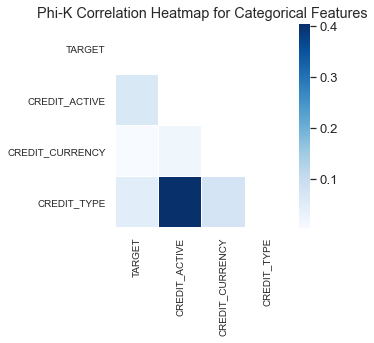

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
0,CREDIT_ACTIVE,0.06
2,CREDIT_TYPE,0.05
1,CREDIT_CURRENCY,0.00


----------------------------------------------------------------------------------------------------


In [40]:
cols_for_phik = ['TARGET','CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize = (5,5))

__Observations et conclusions :__
La carte thermique ci-dessus montre les valeurs de corrélation Phi-K entre les valeurs catégorielles.

> À partir du coefficient de corrélation Phi-K, nous voyons que la variable CREDIT_TYPE montre une certaine association avec la variable CREDIT_ACTIVE.

> Nous voyons que les variables catégorielles n'ont pas vraiment une forte association avec la variable TARGET, en particulier la fonctionnalité CREDIT_CURRENCY.

### Correlation Matrix de Features (matrice de corrélation de caractéristiques numériques)

----------------------------------------------------------------------------------------------------


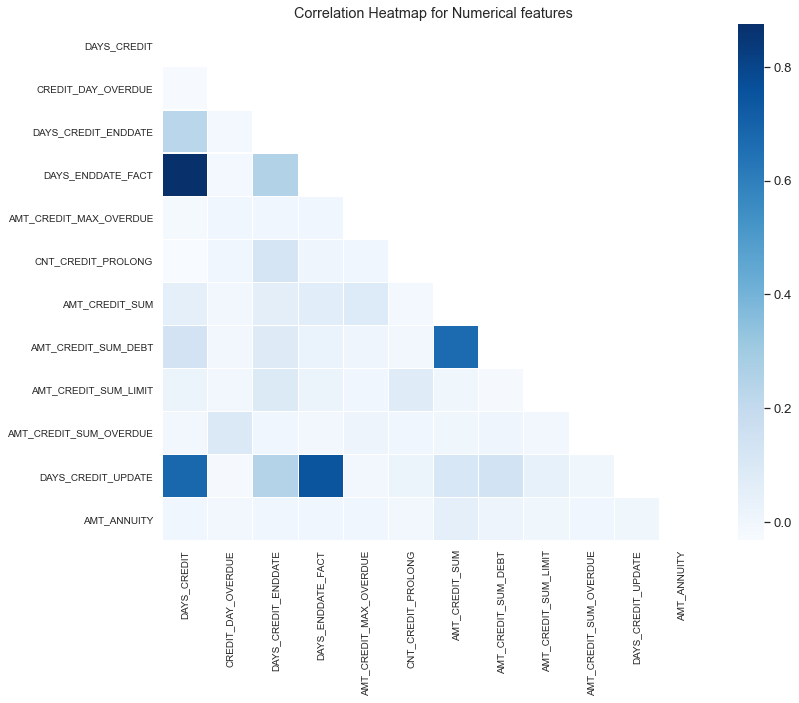

----------------------------------------------------------------------------------------------------


In [41]:
corr_mat = correlation_matrix(bureau_merged, ['SK_ID_CURR','SK_ID_BUREAU'], cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

In [42]:
#Seeing the top columns with highest phik-correlation with the target variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT']
interval columns not set, guessing: ['TARGET', 'CREDIT_DAY_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_ENDDATE']
interval columns not set, guessing: ['TARGET', 'DAYS_ENDDATE_FACT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_MAX_OVERDUE']
interval columns not set, guessing: ['TARGET', 'CNT_CREDIT_PROLONG']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_DEBT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_LIMIT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_UPDATE']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
0,DAYS_CREDIT,0.09
2,DAYS_CREDIT_ENDDATE,0.02
9,AMT_CREDIT_SUM_OVERDUE,0.01
8,AMT_CREDIT_SUM_LIMIT,0.01
4,AMT_CREDIT_MAX_OVERDUE,0.00
5,CNT_CREDIT_PROLONG,0.00
1,CREDIT_DAY_OVERDUE,0.00
10,DAYS_CREDIT_UPDATE,0.00
7,AMT_CREDIT_SUM_DEBT,0.00
6,AMT_CREDIT_SUM,0.00


----------------------------------------------------------------------------------------------------


__Observations et conclusions :__

> La carte thermique ci-dessus montre la corrélation entre chaque fonctionnalité de la table bureau avec le reste des fonctionnalités.
On peut observer que la majeure partie de la carte thermique a des couleurs claires, ce qui montre peu ou pas de corrélation.
Cependant, nous pouvons voir quelques nuances sombres qui représentent une forte corrélation.

> La forte corrélation est particulièrement observée pour les caractéristiques :
        DAYS_CREDIT et DAYS_CREDIT_UPDATE
        DAYS_ENDDATE_FACT et DAYS_CREDIT_UPDATE
        AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT
        DAYS_ENDDATE_FACT et DAYS_CREDIT

> Nous pouvons également voir que les fonctionnalités ne présentent pas particulièrement de corrélation bonne/élevée avec Target en tant que telle, à l'exception de la fonctionnalité DAYS_CREDIT. 

> Cela implique qu'il n'y a pas de relation linéaire directe entre Target et les fonctionnalités.

### Tracé des variables catégorielles

----------------------------------------------------------------------------------------------------
The unique categories of 'CREDIT_ACTIVE' are:
['Closed' 'Active' nan 'Sold' 'Bad debt']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CREDIT_ACTIVE = 5


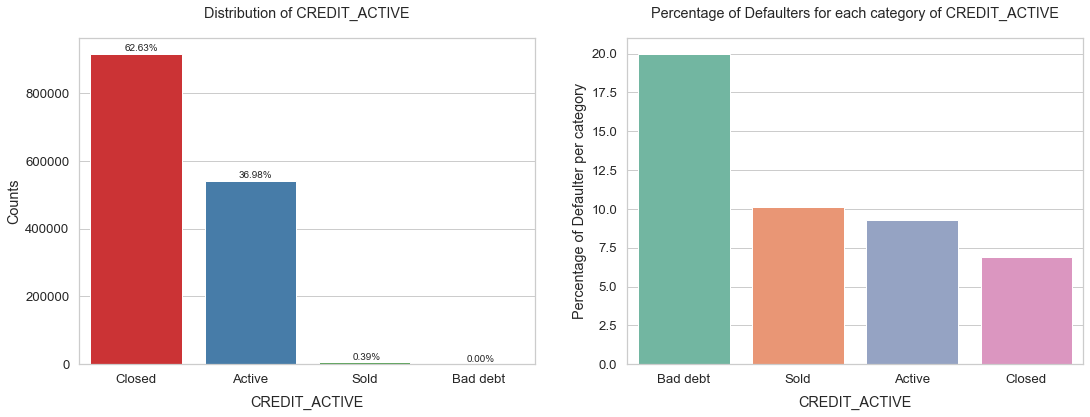

----------------------------------------------------------------------------------------------------


In [43]:
#let us first see the unique categories of 'CREDIT_ACTIVE'
print_unique_categories(bureau_merged, 'CREDIT_ACTIVE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(bureau_merged, column_name = 'CREDIT_ACTIVE', horizontal_adjust = 0.3, fontsize_percent = 'x-small')
print('-'*100)

__Observations et conclusions :__
À partir du graphique ci-dessus, nous pouvons tirer les enseignements suivants :

> À partir de la première sous-intrigue, nous voyons que la majorité des prêts précédents d'autres institutions financières sont des prêts fermés (62,63 %), suivis de 36,98 % des prêts actifs. Les prêts vendus et les créances irrécouvrables sont très moins nombreux.

> Si nous regardons le pourcentage de défaillants par catégorie, nous voyons qu'environ 20% des personnes de Bad-Debt ont fait défaut, ce qui est le taux de défaut le plus élevé. Viennent ensuite les prêts vendus et les prêts actifs. Le taux de défaut le plus bas concerne les prêts fermés, qui présentent un bon historique d'un client. Ainsi, le modèle observé ici est tout à fait logique et attendu.

### Tracé des variables continues (numériques)

#### Nombre de jours de crédit (DAYS_CREDIT)

> Cette colonne décrit le nombre de jours avant la demande actuelle lorsque le client a demandé un crédit auprès du bureau de crédit. Pour faciliter l'interprétation, nous convertirons ces jours en années.

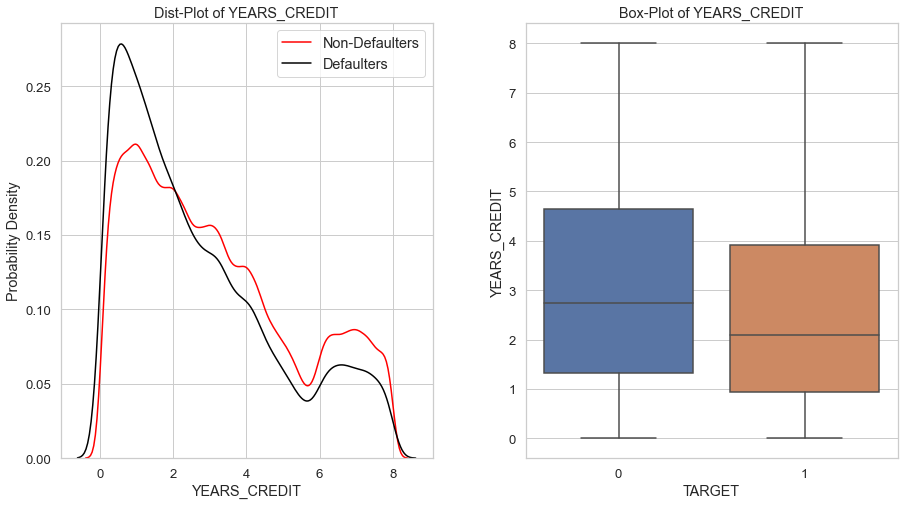

In [44]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (15,8))
_ = bureau_merged.pop('YEARS_CREDIT')

__Observations et conclusions :__

> D'après les graphiques ci-dessus, nous voyons que :

> D'après le PDF, nous voyons que les défaillants ont tendance à avoir des pics plus élevés par rapport aux non défaillants lorsque le nombre d'années est inférieur. appliqué il y a longtemps. Le PDF des défaillants est également un peu vers la gauche par rapport aux non-défauts.

> À partir de la boîte à moustaches également, nous voyons que les défaillants avaient généralement moins de YEARS_CREDIT par rapport aux non-défauteurs.

#### Durée restante du crédit (DAYS_CREDIT_ENDDATE)

> Cette colonne renseigne sur la durée restante du crédit Credit Bureau au moment de la demande de prêt en Crédit Immobilier.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 2th percentile value of DAYS_CREDIT_ENDDATE is -2487.0
The 4th percentile value of DAYS_CREDIT_ENDDATE is -2334.0
The 6th percentile value of DAYS_CREDIT_ENDDATE is -2202.0
The 8th percentile value of DAYS_CREDIT_ENDDATE is -2073.9199999999983
The 10th percentile value of DAYS_CREDIT_ENDDATE is -1939.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1144.0
The 50th percentile value of DAYS_CREDIT_ENDDATE is -334.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is 473.0
The 100th percentile value of DAYS_CREDIT_ENDDATE is 31199.0
----------------------------------------------------------------------------------------------------


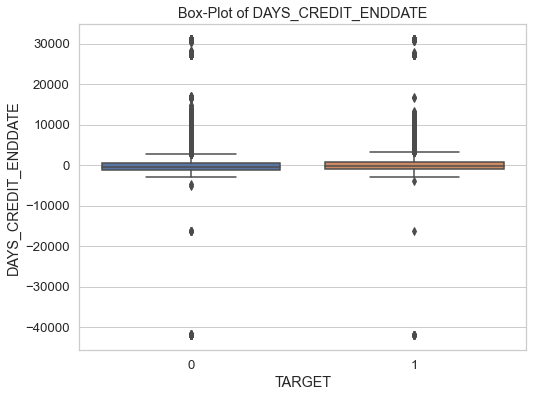

----------------------------------------------------------------------------------------------------


In [45]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_ENDDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))
print('-'*100)

__Observations et conclusions :__

> À partir des valeurs de centile ci-dessus et en regardant la boîte à moustaches, nous voyons qu'il semble y avoir une valeur erronée pour DAYS_CREDIT_ENDDATE, où la valeur du 0e centile remonte à aussi longtemps que 42060 jours ou 115 ans. 

> Cela n'a pas beaucoup de sens car cela implique que le prêt précédent du client remonte à 115 ans. Cela pourrait aussi être un prêt hérité, mais nous ne pouvons pas commenter si sûrement à ce sujet. Nous essaierons de supprimer ces valeurs lors de l'étape de prétraitement des données.

#### Crédits fermés (DAYS_ENDDATE_FACT)

> Cette colonne indique le nombre de jours il y a que le crédit du bureau de crédit avait pris fin au moment de la demande de prêt en crédit immobilier. Ces valeurs ne concernent que les crédits fermés.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENDDATE_FACT is -42023.0
The 2th percentile value of DAYS_ENDDATE_FACT is -2561.0
The 4th percentile value of DAYS_ENDDATE_FACT is -2450.0
The 6th percentile value of DAYS_ENDDATE_FACT is -2351.0
The 8th percentile value of DAYS_ENDDATE_FACT is -2265.0
The 10th percentile value of DAYS_ENDDATE_FACT is -2173.0
The 25th percentile value of DAYS_ENDDATE_FACT is -1503.0
The 50th percentile value of DAYS_ENDDATE_FACT is -900.0
The 75th percentile value of DAYS_ENDDATE_FACT is -427.0
The 100th percentile value of DAYS_ENDDATE_FACT is 0.0
----------------------------------------------------------------------------------------------------


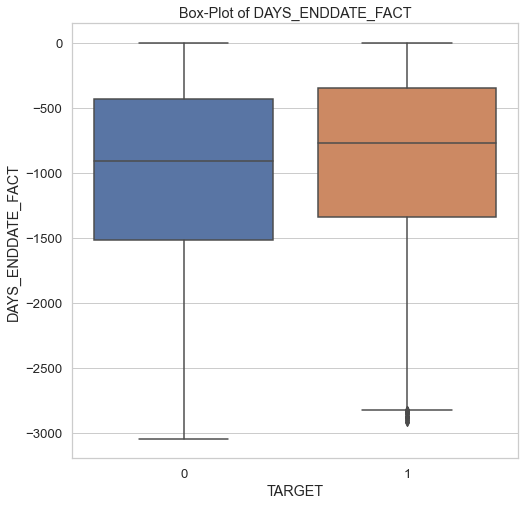

----------------------------------------------------------------------------------------------------


In [46]:
print_percentiles(bureau_merged, 'DAYS_ENDDATE_FACT', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_ENDDATE_FACT', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 0])
print('-'*100)

__Observations et conclusions :__

> Tout comme la colonne précédente, nous voyons que le 0e centile de cette colonne semble également erroné, soit 42023 jours ou ~115 ans. Nous devrions supprimer ces valeurs, car elles n'ont pas beaucoup de sens.

> En regardant le box-plot, nous voyons que les défaillants ont tendance à avoir moins de jours depuis la fin de leur crédit auprès du bureau de crédit. Les non-défauts ont généralement leurs crédits précédents terminés plus longtemps avant que les défaillants.

#### Mise à Jour Date de Crédit (DAYS_CREDIT_UPDATE)

> Cette colonne raconte le nombre de jours il y a que l'information de crédit Bureau de crédit était venu au moment de la demande de prêt en crédit immobilier.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_UPDATE is -41947.0
The 2th percentile value of DAYS_CREDIT_UPDATE is -2415.0
The 4th percentile value of DAYS_CREDIT_UPDATE is -2213.0
The 6th percentile value of DAYS_CREDIT_UPDATE is -2002.0
The 8th percentile value of DAYS_CREDIT_UPDATE is -1766.0
The 10th percentile value of DAYS_CREDIT_UPDATE is -1582.0
The 25th percentile value of DAYS_CREDIT_UPDATE is -904.0
The 50th percentile value of DAYS_CREDIT_UPDATE is -406.0
The 75th percentile value of DAYS_CREDIT_UPDATE is -33.0
The 100th percentile value of DAYS_CREDIT_UPDATE is 372.0
----------------------------------------------------------------------------------------------------


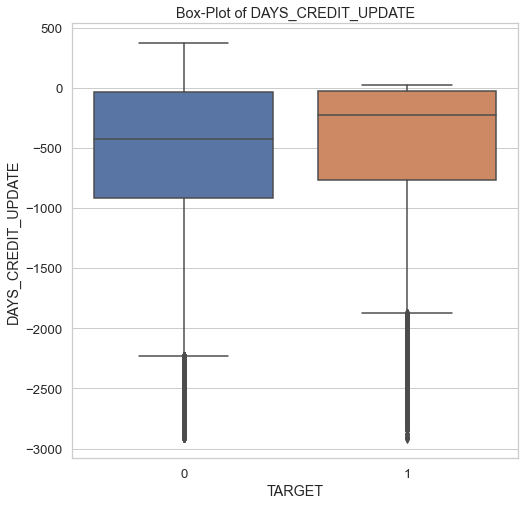

----------------------------------------------------------------------------------------------------


In [47]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_UPDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_UPDATE', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 400])
print('-'*100)

__Observations et conclusions :__

> La tendance des valeurs erronées est à nouveau très similaire à la colonne des autres jours où cette valeur du 0e centile semble être erronée. De plus, étant donné que seule la valeur du 0e centile est si étrange et que le reste semble aller bien, cette valeur est donc définitivement erronée. Nous supprimerons également cette valeur.

> À partir de la boîte à moustaches, nous pouvons dire que les défaillants ont tendance à avoir un nombre de jours inférieur depuis que leurs informations sur le crédit du bureau de crédit ont été reçues. Leurs valeurs médianes au 75e centile sont toutes inférieures à celles des non-défauts.

## Bureau Balance Data (bureau_balance.csv)

Cette base de données comprend le solde mensuel de chaque crédit pour chacun des crédits précédents que le client avait auprès d'institutions financières autres que Home Credit.

In [48]:
print(f'The shape of bureau_balance.csv is: {bureau_balance.shape}')
print('-'*100)
print(f'Number of duplicate values in bureau_balance: {bureau_balance.shape[0] - bureau_balance.duplicated().shape[0]}')
print('-'*100)
display(bureau_balance.head(5))

The shape of bureau_balance.csv is: (27299925, 3)
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [49]:
print("-"*100)
print(f'Number of unique SK_ID_BUREAU in bureau_balance.csv are: {len(bureau_balance.SK_ID_BUREAU.unique())}')
print('-'*100)
print(f'Number of unique values for STATUS are: {len(bureau_balance.STATUS.unique())}')
print(f"Unique values of STATUS are:\n{bureau_balance.STATUS.unique()}")
print('-'*100)
print(f"Max number of months for Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau_balance.csv are: 817395
----------------------------------------------------------------------------------------------------
Number of unique values for STATUS are: 8
Unique values of STATUS are:
['C' '0' 'X' '1' '2' '3' '5' '4']
----------------------------------------------------------------------------------------------------
Max number of months for Months Balance: 96
----------------------------------------------------------------------------------------------------


__Observations et conclusions__

> La table bureau_balance.csv contient environ 27,29 millions de lignes et 3 colonnes.

> Ce tableau contient le statut mensuel de chacun des prêts précédents pour un demandeur particulier signalé par le service du bureau de crédit.

> Il y a 8 valeurs uniques pour le STATUS qui sont codées. Chacun d'eux a une signification particulière.

        C signifie fermé (close),
        X signifie statut inconnu,
        0 signifie pas de DPD (Dépassement de Délai),
        1 signifie maximum fait pendant le mois entre 1-30,
        2 signifie DPD 31-60,
        … 
        5 signifie DPD 120+ ou vendu ou radié.

> Le solde du mois le plus ancien que nous ayons est le statut en arrière de 96 mois, c'est-à-dire que le statut a été fourni jusqu'à 8 ans d'historique pour les prêts pour lesquels ils existent.

### Bureau Balance Data : NaN Columns and Percentages

In [50]:
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance')

The dataframe bureau_balance does not contain any NaN values.


## Previous Application Data (previous_application.csv)

> Cette base de données contient les données statiques du prêt précédent que le client avait avec Home Credit.

In [51]:
print(f'The shape of previous_application.csv is: {previous_application.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in previous_application.csv are: {len(previous_application.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in previous_application.csv are: {len(previous_application.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in previous_application: {previous_application.shape[0] - previous_application.duplicated().shape[0]}')
print('-'*100)
display(previous_application.head(5))

The shape of previous_application.csv is: (1670214, 37)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in previous_application.csv are: 1670214
Number of unique SK_ID_CURR in previous_application.csv are: 338857
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: 291057
Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: 47800
----------------------------------------------------------------------------------------------------
Number of duplicate values in previous_application: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43,17145.00,17145.00,0.00,17145.00,SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,365243.00,-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,25188.62,607500.00,679671.00,nan,607500.00,THURSDAY,11,Y,1,nan,nan,nan,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,365243.00,-134.00,916.00,365243.00,365243.00,1.00
2,2523466,122040,Cash loans,15060.74,112500.00,136444.50,nan,112500.00,TUESDAY,11,Y,1,nan,nan,nan,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,365243.00,-271.00,59.00,365243.00,365243.00,1.00
3,2819243,176158,Cash loans,47041.33,450000.00,470790.00,nan,450000.00,MONDAY,7,Y,1,nan,nan,nan,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,365243.00,-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,31924.40,337500.00,404055.00,nan,337500.00,THURSDAY,9,Y,1,nan,nan,nan,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,nan,nan,nan,nan,nan,nan


__Observations et conclusions :__

> Le tableau previous_application.csv se compose de 1,67 million de lignes au total. Chaque ligne correspond à chacun des prêts précédents que le client avait contractés auparavant avec Home Credit Group. Il est possible pour un seul client de la demande en cours d'avoir plusieurs prêts antérieurs avec Home Credit Group.

> Il y a 37 colonnes dans previous_application.csv, qui contiennent les détails du prêt précédent.

> Il y a 338k SK_ID_CURR uniques dans previous_application, dont 291k correspondent aux applications_train SK_ID_CURRs et 47.8k correspondent aux application_test SK_ID_CURRs.

### Previous Application Data : NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 16 columns


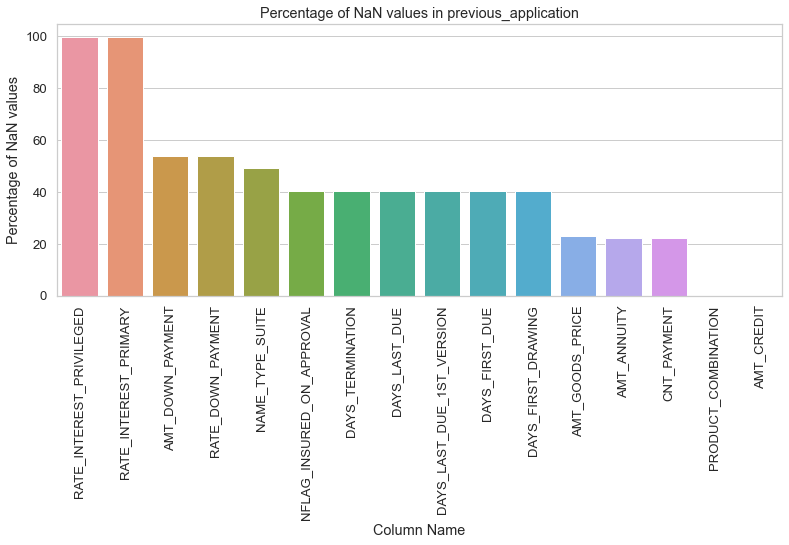

----------------------------------------------------------------------------------------------------


In [52]:
previous_application_nan = nan_df_create(previous_application)
print('-' * 100)
plot_nan_percent(previous_application_nan, 'previous_application', tight_layout = False, figsize = (13,5))
print('-' * 100)
del previous_application_nan

__Observations et conclusions__

> Il y a 16 colonnes sur les 37 colonnes qui contiennent des valeurs NaN.

> Deux de ces colonnes ont des valeurs manquantes à 99,64%, ce qui est très élevé, et nous devrons trouver un moyen intelligent de gérer des valeurs NaN aussi élevées. Nous ne pouvons pas rejeter directement une caractéristique à ce stade.

> Outre ces deux colonnes, le reste des colonnes contient également des valeurs NaN > 40 %, à l'exception de 5 colonnes.

### Fusion des TARGETS (application_train + previous_application)

In [53]:
print("-"*100)
print("Merging TARGET with previous_application Table")
prev_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table
----------------------------------------------------------------------------------------------------


### Phi-K Matrix (matrice de corrélation de caractéristiques catégorielles)

----------------------------------------------------------------------------------------------------


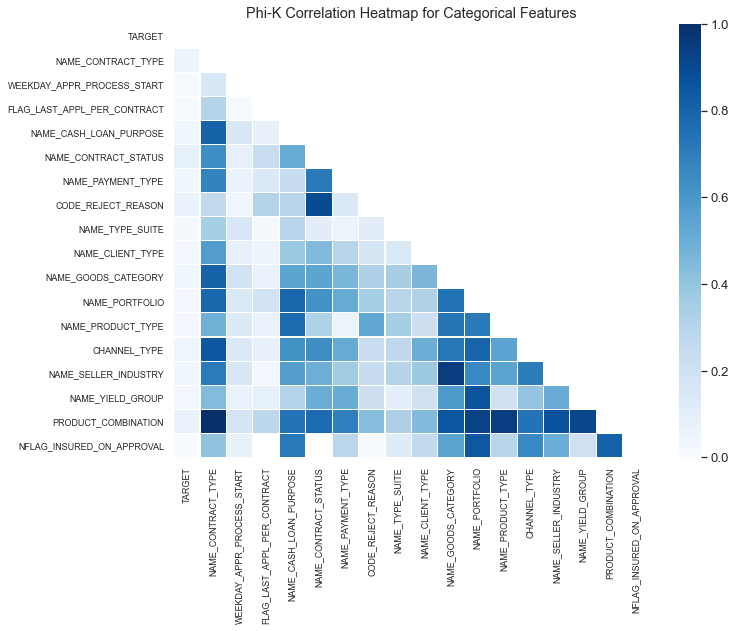

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
4,NAME_CONTRACT_STATUS,0.09
15,PRODUCT_COMBINATION,0.06
6,CODE_REJECT_REASON,0.06
0,NAME_CONTRACT_TYPE,0.05
12,CHANNEL_TYPE,0.05
9,NAME_GOODS_CATEGORY,0.04
3,NAME_CASH_LOAN_PURPOSE,0.04
5,NAME_PAYMENT_TYPE,0.04
13,NAME_SELLER_INDUSTRY,0.04
14,NAME_YIELD_GROUP,0.03


----------------------------------------------------------------------------------------------------


In [54]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap = 'Blues', figsize = (11,9), fontsize = 9)

Observations et conclusions :
À partir de la carte thermique ci-dessus des valeurs du coefficient Phi-K pour les caractéristiques catégorielles, nous observons que :

La fonctionnalité PRODUCT_COMBINATION montre une association avec de nombreuses autres fonctionnalités telles que NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
La fonctionnalité NAME_GOODS_CATEGORY est également fortement associée à NAME_SELLER_INDUSTRY
Si nous examinons l'association avec la variable TARGET, nous voyons que les fonctionnalités NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON sont parmi les fonctionnalités les plus associées et nécessiteraient une enquête plus approfondie

### Correlation Matrix de Features (matrice de corrélation de caractéristiques numériques)

----------------------------------------------------------------------------------------------------


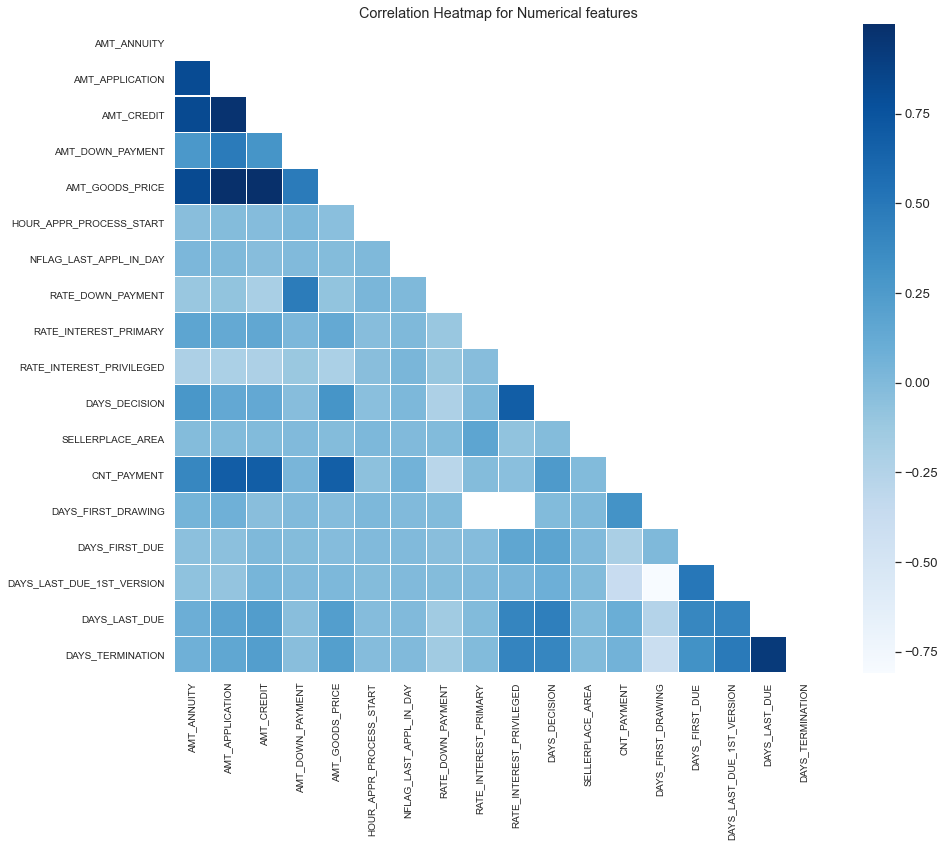

----------------------------------------------------------------------------------------------------


In [55]:
corr_mat = correlation_matrix(prev_merged, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'Blues', figsize = (14,12))
corr_mat.plot_correlation_matrix()

In [56]:
#Seeing the top columns with highest phik-correlation with the target variable in previous_applications table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

,Column Name,Phik-Correlation
12,CNT_PAYMENT,0.06
10,DAYS_DECISION,0.05
13,DAYS_FIRST_DRAWING,0.05
7,RATE_DOWN_PAYMENT,0.04
5,HOUR_APPR_PROCESS_START,0.04
9,RATE_INTEREST_PRIVILEGED,0.03
15,DAYS_LAST_DUE_1ST_VERSION,0.03
16,DAYS_LAST_DUE,0.03
17,DAYS_TERMINATION,0.03
0,AMT_ANNUITY,0.01


----------------------------------------------------------------------------------------------------


__Observations et conclusions :__
La carte thermique ci-dessus montre la corrélation entre chaque fonctionnalité de la table previous_application avec le reste des fonctionnalités.
À partir de la carte thermique, nous pouvons voir certaines caractéristiques fortement corrélées qui ont une couleur plus foncée.
La forte corrélation est particulièrement observée pour les caractéristiques :
DAYS_TERMINATION et DAYS_LAST_DUE
AMT_CREDIT et AMT_APPLICATION
AMT_APPLICATION et AMT_GOODS_PRICE
AMT_CREDIT et AMT_ANNUITY
AMT_ANNUITY et AMT_CREDIT
AMT_CREDIT et AMT_GOODS_PRICE
Nous pouvons également voir que les caractéristiques ne montrent pas particulièrement de corrélation bonne/élevée avec Target en tant que tel. Cela implique qu'il n'y a pas beaucoup de relation linéaire directe entre Target et les fonctionnalités.

### Tracé des variables catégorielles

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


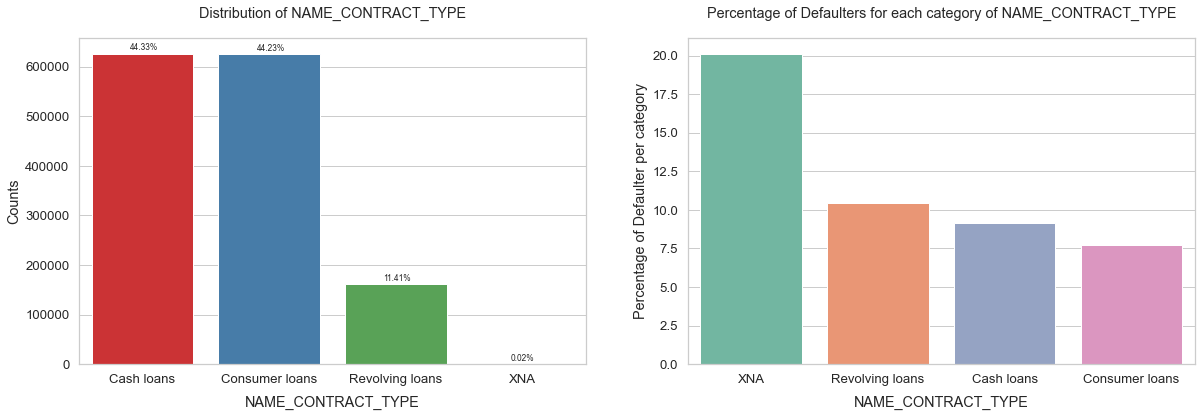

----------------------------------------------------------------------------------------------------


In [57]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust = 0.3, figsize = (20, 6))
print('-'*100)

Observations et conclusions :
A partir des graphiques ci-dessus, nous pouvons observer ce qui suit :

À partir de la première sous-intrigue, nous voyons que la plupart des prêts précédents étaient soit des prêts de trésorerie, soit des prêts à la consommation, ce qui correspond à environ 44% des prêts chacun. Les 11,41% restants correspondent aux prêts renouvelables, et il existe des prêts nommés XNA dont les types ne sont en réalité pas connus, mais ils sont très peu nombreux.
En regardant la deuxième sous-intrigue, nous voyons que le pourcentage de défaillants pour le type de prêt XNA est le plus élevé, avec un taux de défaut de 20 %. Le deuxième taux de défaut le plus élevé se situe parmi les prêts renouvelables, qui est proche de 10,5%.
Les prêts de trésorerie ont des taux de défaut inférieurs, environ 9%, tandis que les prêts à la consommation ont tendance à avoir le pourcentage de défauts de paiement le plus bas, qui est proche de 7,5%.

#### Statuts des crédits (en cours/fermé)

> Cette colonne décrit l'état du contrat du précédent crédit avec Home Credit, c'est-à-dire s'il est actif ou clôturé, etc.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


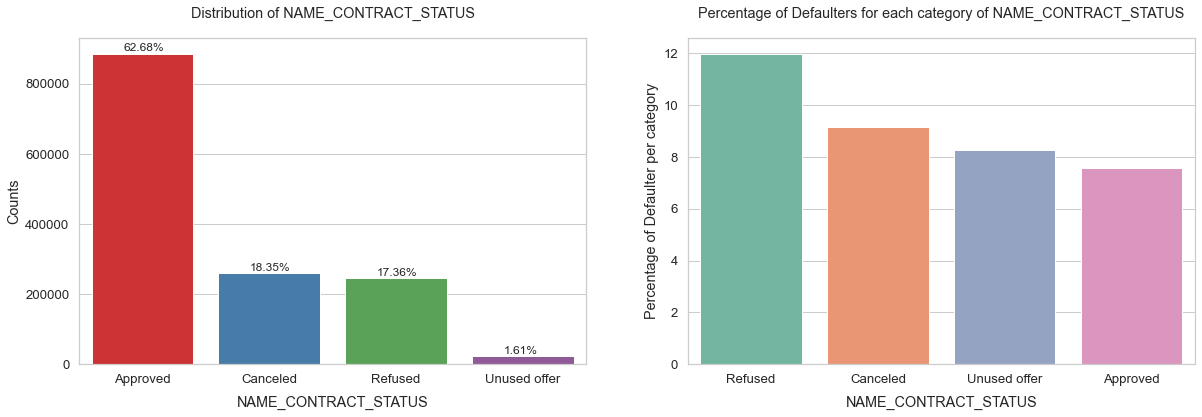

----------------------------------------------------------------------------------------------------


In [58]:
#let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

Observations et conclusions :
D'après les graphiques ci-dessus, nous voyons que :

Le type de statut de contrat le plus courant est le statut approuvé. Environ 63% des crédits précédents ont un statut approuvé. Les deux prochains statuts communs sont Annulé et Refusé, qui correspondent tous deux à environ 18 % des prêts. Cela implique que la plupart des prêts sont approuvés et que seule une partie d'entre eux ne le sont pas. Le type de statut de contrat le moins présent est l'offre non utilisée qui correspond à seulement 1,61% de tous les prêts.
En examinant la deuxième sous-parcelle pour le pourcentage de défaillants, nous voyons que les prêts qui avaient précédemment le statut de refus ont tendance à avoir le plus grand défaut de paiement parmi les prêts actuels. Ils correspondent à environ 12 % des défaillants de cette catégorie. Ceux-ci sont suivis du Statut Annulé qui correspond à près de 9 % du Taux de Défaut. Ce comportement est assez logiquement attendu, car ces personnes ont dû être refusées faute de profil adéquat. Le taux de défaut le moins élevé est observé pour le statut de contrat approuvé.

#### Raison du rejet du prêt précédemment appliqué dans Home Credit Group.

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_REJECT_REASON' are:
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
----------------------------------------------------------------------------------------------------
Counts of each category are:
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: CODE_REJECT_REASON, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CODE_REJECT_REASON = 10


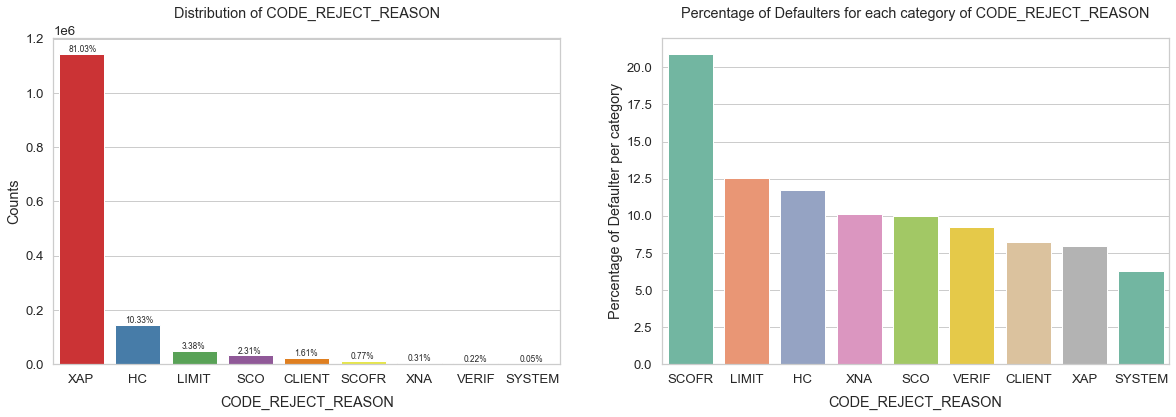

----------------------------------------------------------------------------------------------------


In [59]:
#let us first see the unique categories of 'CODE_REJECT_REASON'
print_unique_categories(prev_merged, 'CODE_REJECT_REASON', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CODE_REJECT_REASON', horizontal_adjust = 0.18, figsize = (20, 6))
print('-'*100)

Observations et conclusions :
Le graphique ci-dessus montre la distribution de la variable catégorielle CODE_REJECT_REASON. Les informations suivantes peuvent être générées à partir du graphique ci-dessus :

Le type de motif de rejet le plus courant est le XAP, qui représente environ 81 %. Les autres motifs ne constituent qu'une petite partie des motifs de rejet. HC est la deuxième raison de rejet la plus élevée avec seulement 10,33% des occurrences.
La répartition du pourcentage de défaillants pour chaque catégorie de CODE_REJECT_REASON est assez intéressante. Les candidats dont les demandes précédentes ont été rejetées par le code SCOFT ont le pourcentage le plus élevé de défaillants parmi eux (~21%). Viennent ensuite LIMIT et HC qui comptent environ 12,5% et 12% de défaillants.
La raison de rejet la plus courante XAP correspond à seulement 7,5% de tous les défaillants et est le deuxième pourcentage le plus bas de défaillants après le code SYSTEM.

#### Canal par lequel le client a acquis le prêt précédent en crédit immobilier.

----------------------------------------------------------------------------------------------------
The unique categories of 'CHANNEL_TYPE' are:
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CHANNEL_TYPE = 9


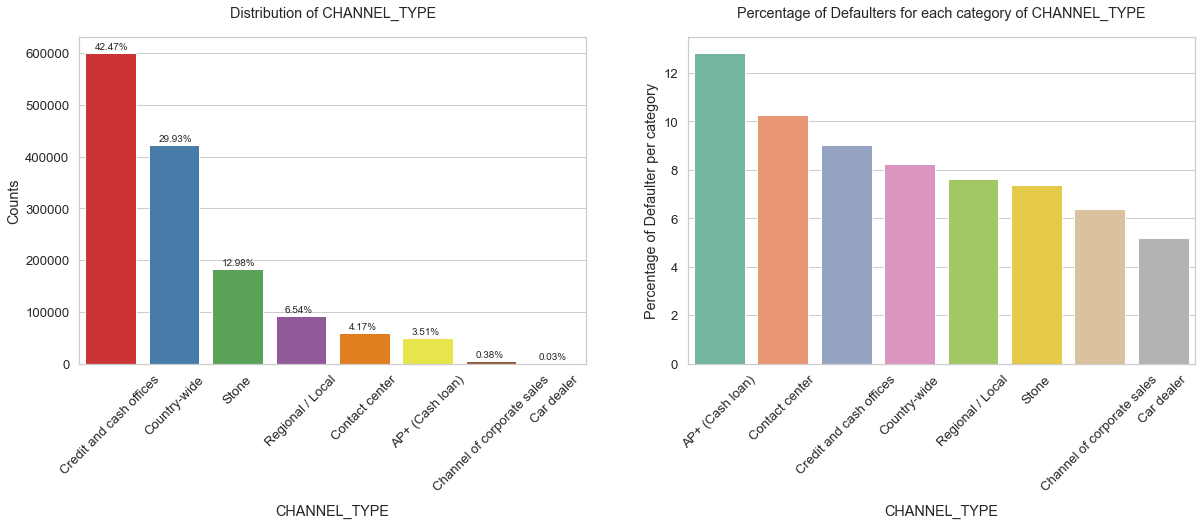

----------------------------------------------------------------------------------------------------


In [60]:
#let us first see the unique categories of 'CHANNEL_TYPE'
print_unique_categories(prev_merged, 'CHANNEL_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust = 0.15, rotation = 45, figsize = (20, 6), fontsize_percent = 'x-small')
print('-'*100)

Observations et conclusions
Les deux graphiques ci-dessus montrent la distribution de CHANNEL_TYPE pour les prêts précédents en crédit immobilier.

Dès la première sous-intrigue, nous voyons que la plupart des applications ont été acquises via les bureaux de crédit et de caisse, ce qui représente environ 42,47% des applications, suivies par le canal national correspondant à 29,93% des applications. Les autres types de canaux ne correspondaient qu'à un nombre restreint d'applications.
Le pourcentage de défaut de paiement le plus élevé a été observé parmi les applications qui avaient un type de canal AP+ (prêt en espèces), ce qui correspondait à environ 13 % de défauts de paiement dans cette catégorie. Les autres chaînes avaient des pourcentages par défaut inférieurs à celui-ci. Le concessionnaire automobile de la chaîne a affiché le plus faible pourcentage de défaillants dans cette catégorie (seulement 5 %).

#### détails sur la combinaison de produits des applications précédentes

----------------------------------------------------------------------------------------------------
The unique categories of 'PRODUCT_COMBINATION' are:
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of PRODUCT_COMBINATION = 18


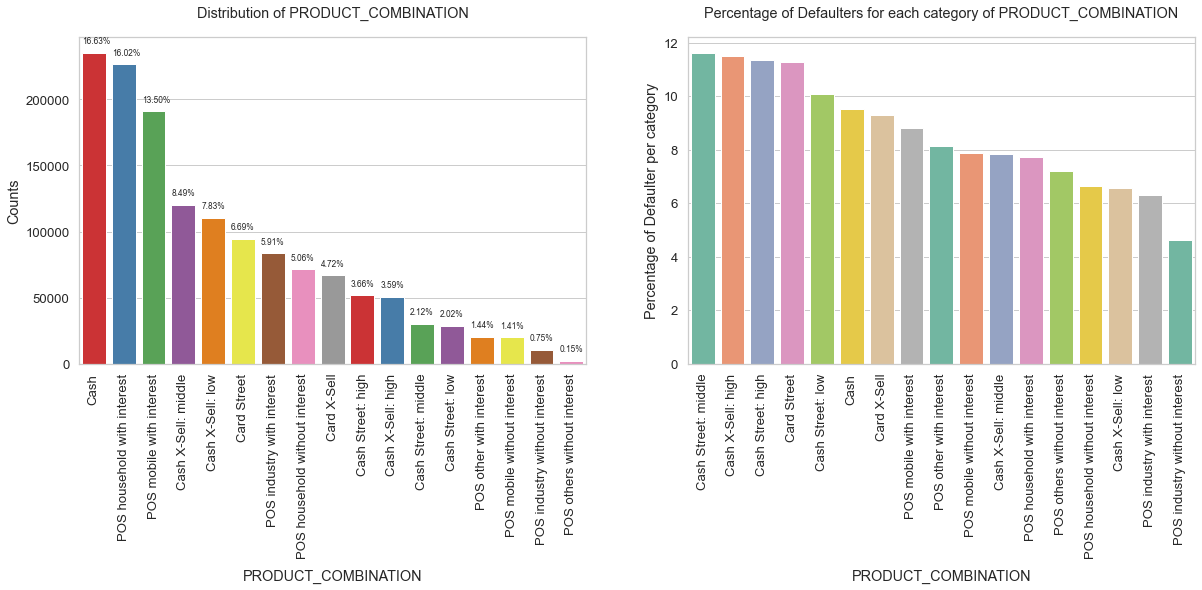

----------------------------------------------------------------------------------------------------


In [61]:
#let us first see the unique categories of 'PRODUCT_COMBINATION'
print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'PRODUCT_COMBINATION', rotation = 90, figsize = (20, 6))
print('-'*100)

Observations et conclusions
À partir de la distribution de PRODUCT_COMBINATION, nous pouvons générer les informations suivantes :

Les 3 types de combinaison de produits les plus courants sont les espèces, les ménages POS avec intérêt et les POS mobiles avec intérêts. Ils correspondent à environ 50 % de l'ensemble des candidatures.
En examinant le graphique du pourcentage de défaillants par catégorie, nous constatons une tendance au défaut la plus élevée parmi Cash Street : catégorie mobile, Cash X-sell : élevé, Cash Street : élevé et Card Street qui sont tous proches d'environ 11 à 11,5 % de défaillants par catégorie. Le pourcentage le plus faible de défaillants se trouve dans la catégorie de l'industrie des points de vente sans intérêt, ce qui correspond à environ 4,5 % de défaillants.

### Tracé des variables continues (numériques)

#### Délai de réponse (DAYS_DECISION)

> Cette colonne indique le nombre de jours relatifs à la demande en cours lorsque la décision a été prise concernant la demande précédente.

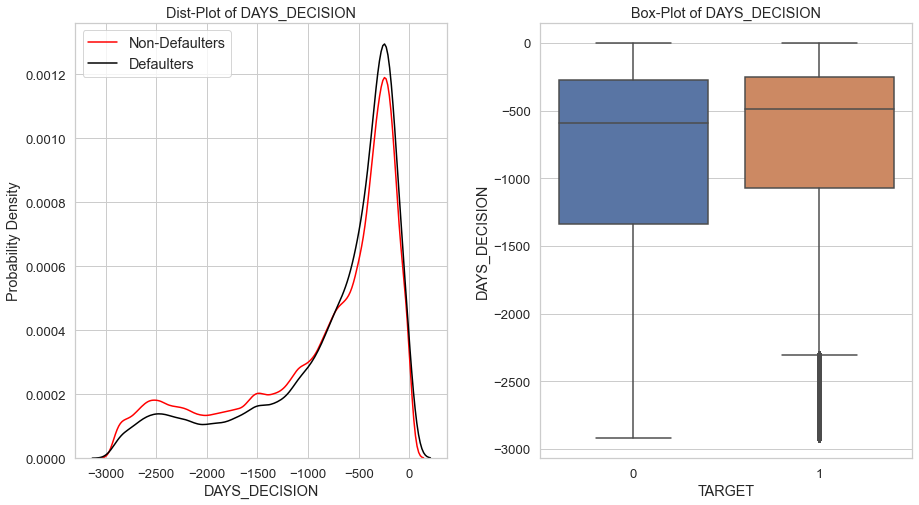

In [62]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8))

Observations et conclusions
D'après le graphique ci-dessus, nous remarquons que pour les défaillants, le nombre de jours en arrière lorsque la décision a été prise est un peu inférieur à celui des non-défauts. Cela implique que les défaillants ont généralement eu la décision sur leurs demandes antérieures rendues plus récemment par rapport aux non-défaillants.

#### Délai de décaissement (DAYS_FIRST_DRAWING)

> Cette colonne indique le nombre de jours depuis la demande en cours pendant lesquels le premier décaissement de la demande précédente a été effectué.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DRAWING is -2922.0
The 1th percentile value of DAYS_FIRST_DRAWING is -2451.0
The 2th percentile value of DAYS_FIRST_DRAWING is -1179.0
The 3th percentile value of DAYS_FIRST_DRAWING is -674.0
The 4th percentile value of DAYS_FIRST_DRAWING is -406.0
The 5th percentile value of DAYS_FIRST_DRAWING is -262.0
The 6th percentile value of DAYS_FIRST_DRAWING is -156.0
The 7th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 8th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 9th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 10th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 20th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 40th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 60th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 80th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 100th percentile

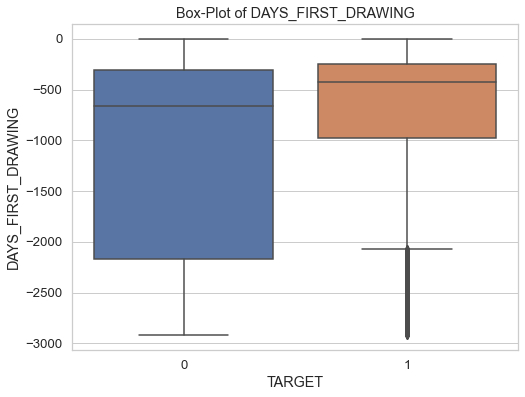

----------------------------------------------------------------------------------------------------


In [63]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING', percentiles = list(range(0,11)) + list(range(20,101,20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots = ['box'], figsize = (8,6), scale_limits = [-3000,0])
print('-'*100)

Observations et conclusions :
En regardant les valeurs de centile de DAYS_FIRST_DRAWING, il semble que la plupart des valeurs soient erronées, à partir des valeurs du 7e centile elle-même. Ces valeurs erronées devront être dopées.
Si nous essayons d'analyser la distribution de cette colonne en supprimant les points erronés, nous voyons que la plupart des défaillants ont eu leur premier tirage sur le crédit précédent plus récemment par rapport aux non-défauts. La valeur du 75e centile pour les défaillants est également nettement inférieure à celle des non-défauts.

#### Suivi des actes (DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, and DAYS_TERMINATION)

> Ces colonnes décrivent également le nombre de jours depuis l'application actuelle pendant lesquels certaines activités se sont produites.

In [64]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DUE is -2892.0
The 2th percentile value of DAYS_FIRST_DUE is -2759.0
The 4th percentile value of DAYS_FIRST_DUE is -2648.0
The 6th percentile value of DAYS_FIRST_DUE is -2555.0
The 8th percentile value of DAYS_FIRST_DUE is -2471.0
The 10th percentile value of DAYS_FIRST_DUE is -2388.0
The 20th percentile value of DAYS_FIRST_DUE is -1882.0
The 40th percentile value of DAYS_FIRST_DUE is -1070.0
The 60th percentile value of DAYS_FIRST_DUE is -647.0
The 80th percentile value of DAYS_FIRST_DUE is -329.0
The 100th percentile value of DAYS_FIRST_DUE is 365243.0
----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
------------

Observations et conclusions
De toutes les valeurs centiles ci-dessus, nous nous rendons compte que toutes les colonnes Jours ont ces valeurs erronées quelque part ou l'autre. Ainsi, ces valeurs doivent être remplacées afin que notre modèle ne soit pas affecté par celles-ci.

## Installments Payments data (installments_payments.csv)

Cette base de données répertorie l'historique de remboursement de chacun des prêts que le demandeur avait avec Home Credit Group. Le tableau contient des caractéristiques telles que le montant du versement, combien le client a-t-il payé pour chaque versement, etc.

In [65]:
print(f'The shape of installments_payments.csv is: {installments_payments.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(installments_payments.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(installments_payments.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in installments_payments: {installments_payments.shape[0] - installments_payments.duplicated().shape[0]}')
print('-'*100)
display(installments_payments.head(5))

The shape of installments_payments.csv is: (13605401, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in installments_payments.csv are: 997752
Number of unique SK_ID_CURR in installments_payments.csv are: 339587
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 291643
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 47944
----------------------------------------------------------------------------------------------------
Number of duplicate values in installments_payments: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,-1180.00,-1187.00,6948.36,6948.36
1,1330831,151639,0.00,34,-2156.00,-2156.00,1716.53,1716.53
2,2085231,193053,2.00,1,-63.00,-63.00,25425.00,25425.00
3,2452527,199697,1.00,3,-2418.00,-2426.00,24350.13,24350.13
4,2714724,167756,1.00,2,-1383.00,-1366.00,2165.04,2160.59


Observations et conclusions
Il y a environ 13,6 millions de points de données dans la table versements_payments.csv. Chaque ligne représente chaque historique de versements lié à un prêt particulier que le client avait précédemment avec Home Credit Group.
Il y a 997 000 prêts précédents uniques dans les versements_versements. Ceux-ci appartiennent à 339k SK_ID_CURR uniques, qui sont les identifiants des demandeurs de prêt en cours.
Sur ces 339 000 SK_ID_CURR, 291 000 appartiennent à l'ensemble de données d'apprentissage et 47,9 000 appartiennent à l'ensemble de données de test. Cela implique que presque sur 307 000 SK_ID_CURR uniques dans application_train, 291 000 avaient auparavant une forme de prêt avec Home Credit. De même, pour 48,7 000 de ceux dans l'ensemble de données de test, 47,9 000 avaient déjà un prêt avec Home Credit.
Le tableau comporte 8 caractéristiques uniques, dont 6 décrivent les statistiques de chaque versement pour le prêt précédent.

### Installments Payments data : NaN Columns and Percentages

In [66]:
print('-'*100)
print("Columns with NaN values and their percentages:")
installments_payments_nan = nan_df_create(installments_payments)
display(installments_payments_nan[installments_payments_nan.percent != 0])
print('-'*100)
del installments_payments_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
5,DAYS_ENTRY_PAYMENT,0.02
7,AMT_PAYMENT,0.02


----------------------------------------------------------------------------------------------------


Observations et conclusions
Il n'y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de versements_paiements.
Ces colonnes contiennent également une proportion très minime de valeurs NaN, c'est-à-dire seulement 0,02%, ce n'est donc pas très préoccupant.

### Fusion des TARGETS (application_train + versements_payments)

In [67]:
print("-"*100)
print("Merging TARGET with installments_payments Table")
installments_merged = application_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with installments_payments Table
----------------------------------------------------------------------------------------------------


###  Correlation Matrix de Features (matrice de corrélation de caractéristiques numériques)

----------------------------------------------------------------------------------------------------


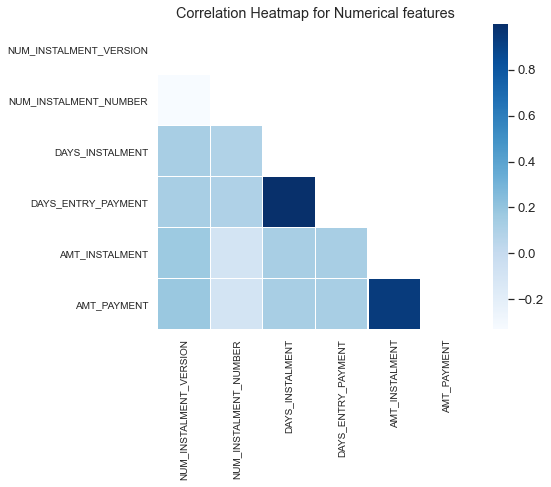

----------------------------------------------------------------------------------------------------


In [68]:
corr_mat = correlation_matrix(installments_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,7))
corr_mat.plot_correlation_matrix()

In [69]:
#Seeing the top columns with highest phik-correlation with the target variable in installments_payments table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
2,DAYS_INSTALMENT,0.05
3,DAYS_ENTRY_PAYMENT,0.03
1,NUM_INSTALMENT_NUMBER,0.02
4,AMT_INSTALMENT,0.00
5,AMT_PAYMENT,0.00
0,NUM_INSTALMENT_VERSION,0.00


----------------------------------------------------------------------------------------------------


Observations et conclusions :
La carte thermique ci-dessus montre la corrélation entre chaque fonctionnalité de la table versements_payments avec le reste des fonctionnalités.
À partir de la carte thermique de la matrice de corrélation, nous voyons quelques caractéristiques hautement corrélées. Ceux-ci sont:
AMT_INSTALMENT et AMT_PAYMENT
DAYS_INSTALMENT et DAYS_ENTRY_PAYMENT
Ces deux ensembles de caractéristiques corrélées sont compréhensibles, car il s'agit en fait des caractéristiques relatives au moment où l'acompte devait être payé par rapport au moment où il a été payé et également au montant dû par rapport au montant qui a été payé.
Ces fonctionnalités seront utiles pour créer de nouveaux ensembles de fonctionnalités complètement non corrélées.
La corrélation des caractéristiques avec la cible n'est pas perceptible, cela montre l'absence de relation linéaire entre la caractéristique et la variable cible.

### Tracé des variables continues (numériques)

> Tout d'abord, nous allons regrouper par le champ 'SK_ID_PREV' et agréger avec la moyenne, de sorte que nous obtenions une ligne moyenne pour chacun des prêts précédents du client.

In [70]:
installments_merged = installments_merged.groupby('SK_ID_PREV').mean()

> Cette colonne liste les jours où l'acompte du crédit précédent devait être payé.

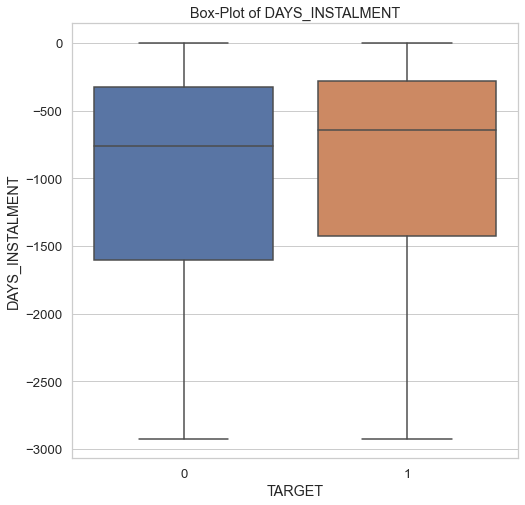

In [71]:
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

> Cette colonne liste les jours où l'acompte du précédent crédit a été effectivement payé.

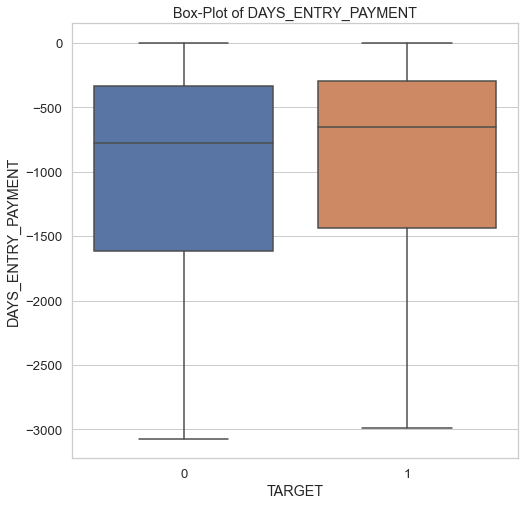

In [72]:
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))
del installments_merged

Observations et conclusions
À partir des deux graphiques ci-dessus, nous pouvons voir un schéma similaire, où les défaillants ont tendance à avoir moins de jours depuis leur dernier paiement, tandis que les non-défauts ont plus de jours depuis leurs derniers paiements. Tous les quantiles de défaillants ont des jours plus récents que ceux des non-défauts. Ainsi, les non-défauts ont généralement plus d'écart dans leurs paiements à partir du jour de la demande par rapport aux défaillants.

## POS CASH Balance Data (POS_CASH_balance.csv)

> Ce tableau contient les instantanés du solde mensuel des précédents points de vente et des prêts en espèces que le demandeur avait avec Home Credit Group. Le tableau contient des colonnes comme le statut du contrat, le nombre de versements restants, etc.

In [73]:
print(f'The shape of POS_CASH_balance.csv is: {POS_CASH_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in POS_CASH_balance: {POS_CASH_balance.shape[0] - POS_CASH_balance.duplicated().shape[0]}')
print('-'*100)
display(POS_CASH_balance.head())

The shape of POS_CASH_balance.csv is: (10001358, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 936325
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 337252
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: 289444
Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: 47808
----------------------------------------------------------------------------------------------------
Number of duplicate values in POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


Observations et conclusions
Ce tableau contient environ 10 millions de points de données, où chaque ligne correspond à l'instantané mensuel de l'état du précédent POS et Cash Loan que le client avait avec Home Credit Group. Il se compose de 8 colonnes, dont deux sont SK_ID_CURR et SK_ID_PREV.
Il y a 936 000 identifiants de prêts précédents uniques dans le tableau, ce qui correspond à 337 000 demandeurs actuels uniques (SK_ID_CURR).
Sur ces 337k SK_ID_CURR, 289k appartiennent à l'ensemble d'apprentissage et 47,8k appartiennent à l'ensemble de test.

### POS CASH Balance Data : NaN Columns and Percentages

In [74]:
print('-'*100)
print("Columns with NaN values and their percentages:")
POS_CASH_nan = nan_df_create(POS_CASH_balance)
display(POS_CASH_nan[POS_CASH_nan.percent != 0])
print('-'*100)
del POS_CASH_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
4,CNT_INSTALMENT_FUTURE,0.26
3,CNT_INSTALMENT,0.26


----------------------------------------------------------------------------------------------------


Observations et conclusions
Il n'y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de POS_CASH_balance. Ces colonnes sont le nombre de versements restants et la durée du prêt.
Ces colonnes contiennent également une proportion très minime de valeurs NaN, c'est-à-dire seulement 0,26%%, ce qui n'est donc pas non plus très préoccupant.

### Fusion des TARGETS (application_train + POS_CASH_balance)

In [75]:
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = application_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


###  Correlation Matrix de Features (matrice de corrélation de caractéristiques numériques)

----------------------------------------------------------------------------------------------------


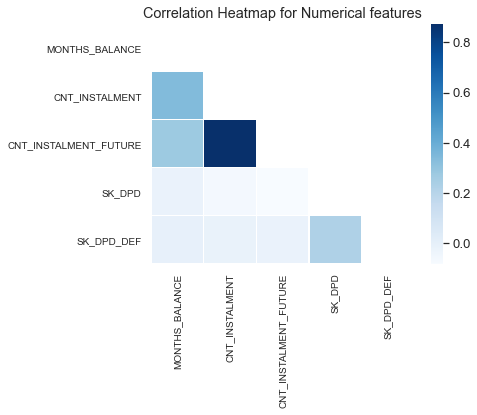

----------------------------------------------------------------------------------------------------


In [76]:
corr_mat = correlation_matrix(pos_cash_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

In [77]:
#Seeing the top columns with highest phik-correlation with the target variable in POS_CASH_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
2,CNT_INSTALMENT_FUTURE,0.03
1,CNT_INSTALMENT,0.03
0,MONTHS_BALANCE,0.03
3,SK_DPD,0.01
4,SK_DPD_DEF,0.01


----------------------------------------------------------------------------------------------------


Observations and Conclusions:
The above heatmap shows the correlation between the fetures
From the heatmap of correlation matrix, we one set of moderately correlated features, which are: CNT_INSTALMENT and CNT_INSTALMENT_FUTURE.
The correlation of features with Target is very low, this shows the absence of a linear relationship between the feature and the target variable.

### Tracé des variables continues (numériques)

> Tout d'abord, nous allons regrouper par le champ 'SK_ID_PREV' et agréger avec la moyenne, de sorte que nous obtenions une ligne moyenne pour chacun des prêts précédents du client.

In [78]:
pos_cash_merged = pos_cash_merged.groupby('SK_ID_PREV').mean()

> Cette colonne décrit le nombre d'acomptes restant à payer sur le crédit précédent.

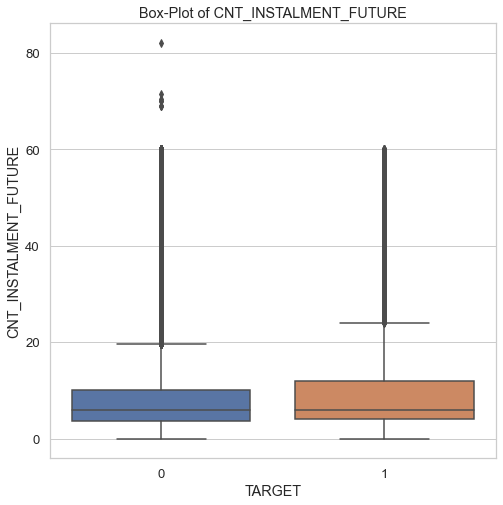

In [79]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
del pos_cash_merged

Observations et conclusions
En regardant la boîte à moustaches ci-dessus pour CNT_INSTALMENT_FUTURE, nous voyons que les valeurs centiles> 50 % pour les défaillants sont généralement plus élevées que celles des non-défauts. Même la moustache de limite supérieure pour les défaillants est plus élevée que celle des non-défauts. Cela suggère que les défaillants ont tendance à avoir plus de versements restants sur leurs crédits précédents par rapport aux non-défauts.

## credit card balance Data (credit_card_balance.csv)

> Ce tableau comprend les données mensuelles relatives à une ou plusieurs cartes de crédit que le demandeur avait avec le groupe de crédit à domicile. Le tableau contient des champs comme le solde, la limite de crédit, le montant des tirages, etc. pour chaque mois de la carte de crédit.

In [80]:
print(f'The shape of credit_card_balance.csv is: {cc_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(cc_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(cc_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Number of duplicate values in credit_card_balance: {cc_balance.shape[0] - cc_balance.duplicated().shape[0]}')
print('-'*100)
display(cc_balance.head(5))

The shape of credit_card_balance.csv is: (3840312, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 86905
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 16653
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,1700.33,1800.00,1800.00,0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,63975.56,45000,2250.00,2250.00,0.00,0.00,2250.00,2250.00,2250.00,60175.08,64875.56,64875.56,1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,31815.22,450000,0.00,0.00,0.00,0.00,2250.00,2250.00,2250.00,26926.42,31460.08,31460.08,0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,236572.11,225000,2250.00,2250.00,0.00,0.00,11795.76,11925.00,11925.00,224949.29,233048.97,233048.97,1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,453919.46,450000,0.00,11547.00,0.00,11547.00,22924.89,27000.00,27000.00,443044.40,453919.46,453919.46,0.00,1,0.00,1.00,101.00,Active,0,0


Observations et conclusions
Il y a environ 3,84 millions de lignes dans la table credit_card_balance.csv, chacune correspondant au statut mensuel de la carte de crédit que le demandeur avait avec Home Credit Group. Ce tableau contient 23 fonctionnalités qui contiennent les statistiques sur le statut de la carte de crédit de chaque mois, telles que le montant du solde, le montant des tirages, le nombre de tirages, le statut, etc.
Il y a 104,3k cartes de crédit uniques dont les détails sont dans ce tableau.
Sur ces 104,3k, il y a 103,5k SK_ID_CURR uniques. Cela signifie que la plupart des candidats n'avaient qu'une seule carte de crédit avec eux, et que peu d'entre eux en avaient plus de 1. Ces SK_ID_CURR sont l'ID des candidats qui ont actuellement demandé un prêt.
Sur les 103 000 SK_ID_CURR uniques, 86,9 000 de ces candidats appartiennent à l'ensemble de formation et 16,6 000 appartiennent à l'ensemble d'applications de test.
Sur les 307 000 candidats figurant dans le tableau application_train, seuls 86,9 000 d'entre eux avaient déjà une carte de crédit auprès de Home Credit Group.

### credit card balance Data : NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


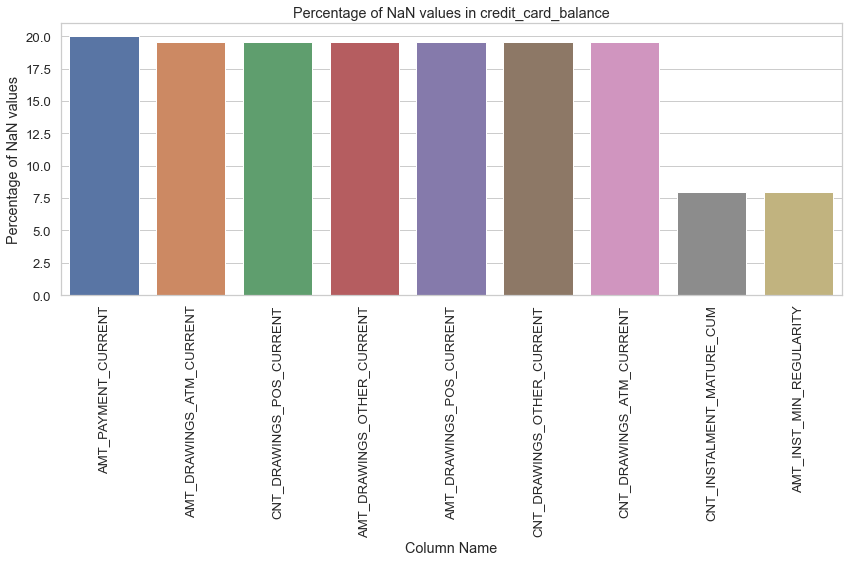

----------------------------------------------------------------------------------------------------


In [81]:
cc_balance_nan = nan_df_create(cc_balance)
print('-'*100)
plot_nan_percent(cc_balance_nan, 'credit_card_balance', tight_layout = False, rotation = 90, figsize = (14,5))
print('-'*100)
del cc_balance_nan

Observations et conclusions
Sur les 23 caractéristiques, 9 de ces caractéristiques contiennent des valeurs NaN.
Si nous regardons les pourcentages de valeurs NaN, ils sont considérablement inférieurs au reste des tableaux que nous avons vus jusqu'à présent.
7 de ces caractéristiques ont des valeurs NaN proches de 20 %. Ces caractéristiques sont principalement liées aux quantités de tirage et au nombre de tirages. Deux autres fonctionnalités sont liées aux statistiques des versements.

### Fusion des TARGETS (application_train + credit_card_balance)

In [82]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
cc_balance_merged = application_train.iloc[:,:2].merge(cc_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


###  Correlation Matrix de Features (matrice de corrélation de caractéristiques numériques)

----------------------------------------------------------------------------------------------------


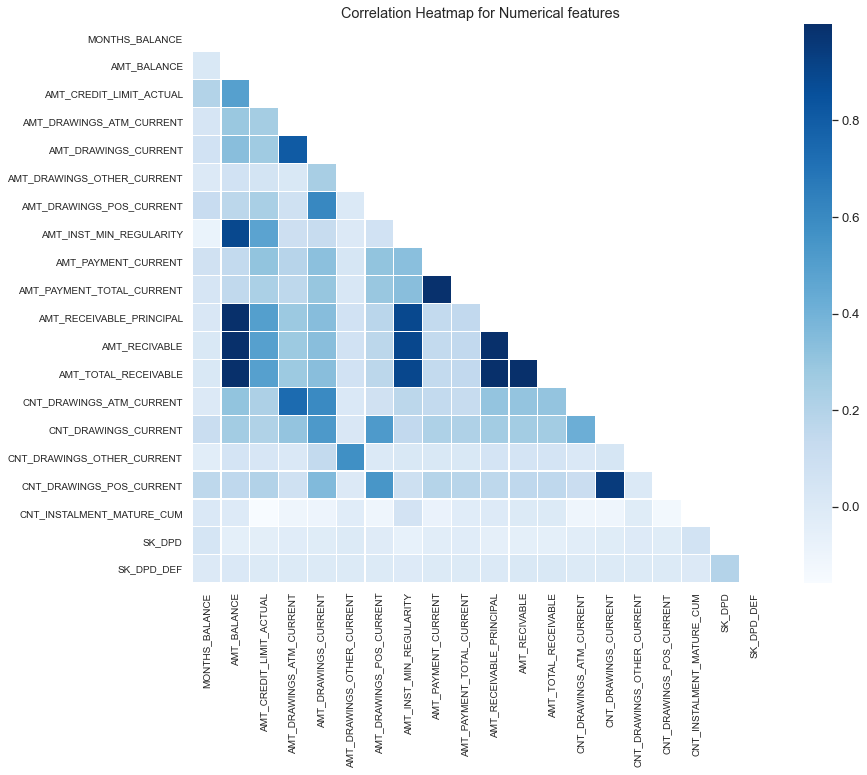

----------------------------------------------------------------------------------------------------


In [83]:
corr_mat = correlation_matrix(cc_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [84]:
#Seeing the top columns with highest phik-correlation with the target variable in credit_card_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

,Column Name,Phik-Correlation
1,AMT_BALANCE,0.06
11,AMT_RECIVABLE,0.06
12,AMT_TOTAL_RECEIVABLE,0.06
10,AMT_RECEIVABLE_PRINCIPAL,0.06
0,MONTHS_BALANCE,0.05
7,AMT_INST_MIN_REGULARITY,0.04
17,CNT_INSTALMENT_MATURE_CUM,0.04
13,CNT_DRAWINGS_ATM_CURRENT,0.03
2,AMT_CREDIT_LIMIT_ACTUAL,0.03
14,CNT_DRAWINGS_CURRENT,0.03


----------------------------------------------------------------------------------------------------


Observations et conclusions :
La carte thermique ci-dessus montre visuellement la corrélation entre les fonctionnalités de la table credit_card_balance.
À partir de la carte thermique de la matrice de corrélation, nous voyons quelques couples de caractéristiques fortement corrélées. Ceux-ci sont:
AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE et AMT_BALANCE
On observe également une forte corrélation entre ces 3 colonnes AMT_RECEIVABLE
AMT_PAYMENT_TOTAL_CURRENT et AMT_PAYMENT_CURRENT
Les ensembles de caractéristiques corrélées 2e et 3e sont compréhensibles car ils racontent plus ou moins la même histoire.
La corrélation des caractéristiques avec la cible n'est pas perceptible, cela montre l'absence de relation linéaire entre la caractéristique et la variable cible.

### Tracé des variables continues (numériques)

> Tout d'abord, nous allons regrouper par le champ 'SK_ID_PREV' et agréger avec la moyenne, de sorte que nous obtenions une ligne moyenne pour chacun des prêts précédents du client.

In [85]:
cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV').mean()

> Cette colonne fournissait le montant moyen du solde qu'une personne avait habituellement sur son compte de prêt de carte de crédit pour un prêt précédent.

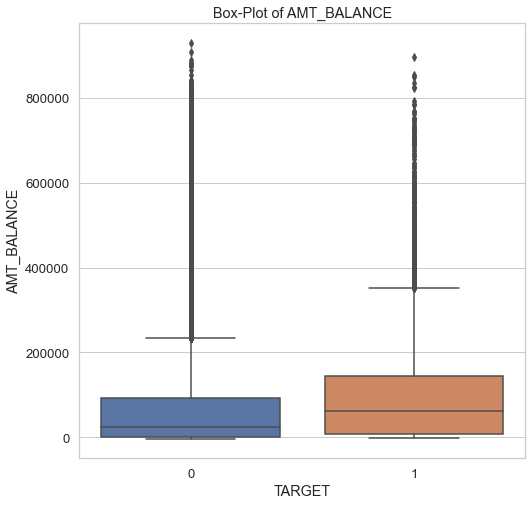

In [86]:
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

Observations et conclusions
D'après le graphique ci-dessus, on peut voir que les défaillants ont une valeur d'AMT_BALANCE plus élevée que les non défaillants. Ils montrent des valeurs plus élevées de tous les quantiles et même des moustaches. Cela pourrait impliquer que le montant du crédit pour les défaillants pourrait également être relativement plus élevé par rapport aux non-défaillants.

Observations et conclusions :
Nous voyons que les défaillants ici aussi semblaient avoir un versement minimum plus élevé chaque mois par rapport aux non-défauts. Cela parle généralement des dépenses et des habitudes d'emprunt de la population. Les défaillants affichent des habitudes de dépenses et d'emprunt plus élevées que les non défaillants.

> Cette colonne décrit la moyenne du montant total à recevoir sur le crédit précédent.

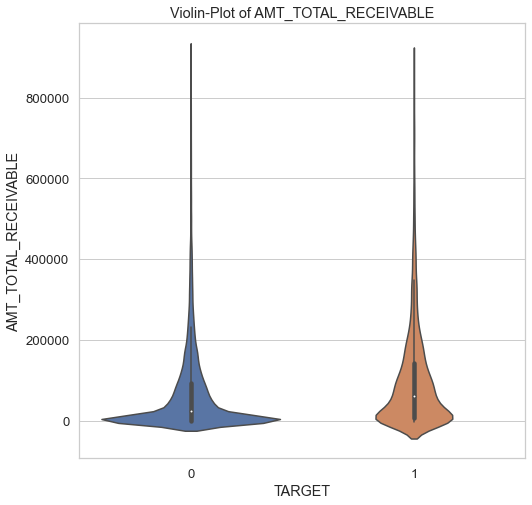

In [87]:
plot_continuous_variables(cc_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (8,8))

Observations et conclusions
En regardant la boîte à moustaches de AMT_TOTAL_RECEIVABLE, nous voyons un comportement similaire à celui observé avec d'autres montants également, à savoir que les défaillants avaient généralement un montant à recevoir plus élevé sur leur crédit précédent, ce qui peut impliquer les montants plus élevés de crédits qu'ils ont pu prendre. Le PDF montre également un pic très élevé à des montants inférieurs pour les non-défauts par rapport aux défaillants.

> La colonne décrit le nombre moyen d'acomptes versés sur les crédits précédents.

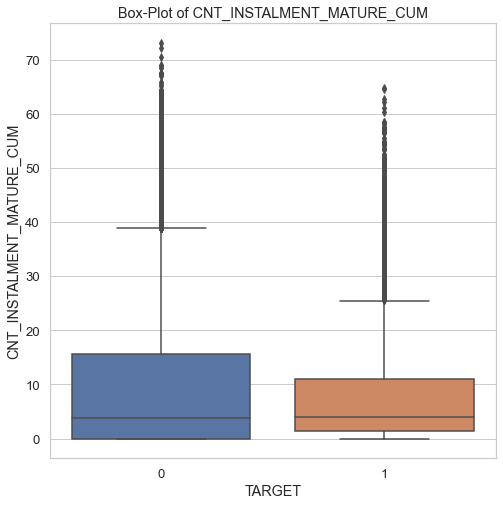

In [88]:
plot_continuous_variables(cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

Observations et conclusions
De l'intrigue ci-dessus, nous voyons un comportement très intéressant. Ce graphique montre que les non-défauts ont généralement une plage de valeurs plus élevée pour le nombre de versements payés par rapport aux défaillants. Cela pourrait montrer le comportement défaillant, où les défaillants paieraient généralement moins de versements sur leur crédit précédent.

Conclusions de l'EDA
À partir de l'analyse exploratoire exhaustive des données que nous avons effectuée, nous pouvons tirer des conclusions de haut niveau de notre ensemble de données donné.

Tout d'abord, l'ensemble de données devra être fusionné avec un moyen ingénieux pour que les données fusionnées aient un sens.
Certaines catégories sont très bien discriminatoires entre les défaillants et les non défaillants, ce qui pourrait être important aux fins de la classification.
Il y a peu de variables numériques continues qui contiennent des points erronés, nous aurions à gérer ces points.
Nous avons également remarqué certaines fonctionnalités corrélées, qui ne feraient qu'augmenter la dimensionnalité des données et n'ajouteraient pas beaucoup de valeur. Nous voudrions supprimer ces fonctionnalités.
Dans l'ensemble, l'ensemble de données est déséquilibré, et nous aurions besoin de trouver des techniques pour gérer un tel déséquilibre.
Pour la prédiction du risque de défaut, les défaillants ont généralement tendance à avoir un comportement qui n'est pas normal et, par conséquent, nous ne pouvons pas supprimer les valeurs aberrantes ou les points éloignés, car ils peuvent suggérer une tendance importante au défaut.
Avec toutes ces informations, nous allons passer à la tâche d'apprentissage des données et d'ingénierie des fonctionnalités.